# Analysis of Tempo (aka Duration)

## Imports

In [1]:
import pandas as pd
import numpy as np

## Reading

In [2]:
def read_to_numpy_with_headers(file_path):
    df = None
    if (file_path[-5:] == '.xlsx'):
        df = pd.read_excel(file_path)
    elif (file_path[-4:] == '.csv'):
        df = pd.read_csv(file_path)
    columns_to_drop = ['Date', 'CodaType', 'Unit', 'UnitNum', 'IDN'] # + ['Clan', ]
    df = df.drop(columns_to_drop, axis=1)
    headers = df.columns.values  # Extract headers

    return df, headers

In [3]:
file_path = "../../../data/dominica-sharma.csv"
initial_df, headers = read_to_numpy_with_headers(file_path)

initial_df.shape, headers

((8719, 13),
 array(['codaNUM2018', 'nClicks', 'Duration', 'ICI1', 'ICI2', 'ICI3',
        'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'Clan'],
       dtype=object))

## Processing

Process tempos only for EC1 clan

In [ ]:
all_tempos = initial_df['Duration'].astype(float)

# Extract the clan labels from the dataset
clans = initial_df['Clan']

# Only use codas (tempos) from the EC1 clan
all_tempos_labelled = []

for i in range(len(clans)):
    if clans[i] == 'EC1':  # Check if the clan is 'EC1'
        all_tempos_labelled.append(all_tempos[i])

# Filter out anomalous annotations by limiting tempos to a specific range
all_tempos_ec1 = []

# Loop through all EC1 clan tempos and apply the filtering criteria
for i in range(len(all_tempos_labelled)):
    if 0.1 < all_tempos_labelled[i] < 1.75:  # Only keep tempos between 0.1 and 1.75
        all_tempos_ec1.append(all_tempos_labelled[i]

f"Number of codas from the EC1 clan: {len(all_tempos_ec1}"

'Number of codas from the EC1 clan: 7737'

Visualize distribution

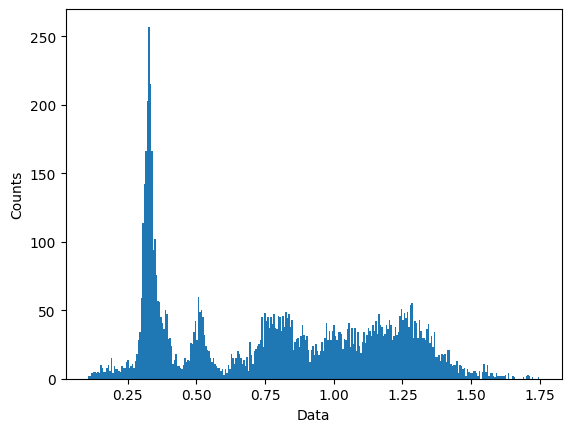

In [ ]:
import matplotlib.pyplot as plt

# Plot the histogram to show distribution of tempo values
plt.hist(all_tempos_ec1, bins=300
plt.ylabel('Counts')
plt.xlabel('Data')
plt.show()

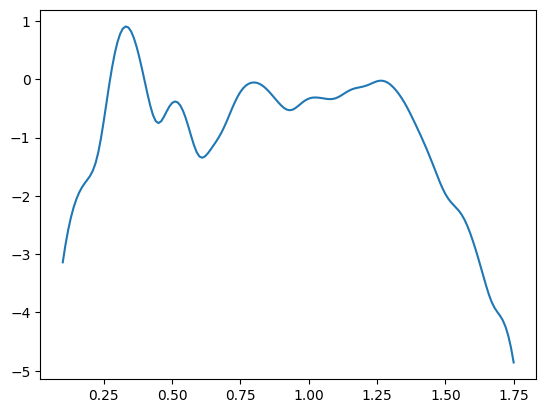

In [6]:
from numpy import array
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot

a = array(all_tempos_ec1).reshape(-1, 1)

# Apply Kernel Density Estimation (KDE) with a Gaussian kernel to estimate the probability density function of the tempos
kde = KernelDensity(kernel='gaussian', bandwidth=0.035).fit(a)
# 'gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'

# Create a range of values (s) over which to evaluate the KDE, spanning the tempo range from 0.1 to 1.75
s = np.arange(0.1, 1.75 + 0.01, 0.01)

# Evaluate the log density (e) of the KDE at each point in 's'
e = kde.score_samples(s.reshape(-1, 1))

# Plot the KDE results, showing how the probability density varies across the tempo range
plot(s, e)
plt.show()

In [7]:
from scipy.signal import argrelextrema

# Identify local minima and maxima in the estimated log density (e)
# 'argrelextrema' finds indices of relative extrema (minima or maxima) in an array

# Find indices of local minima in the density estimate 'e'
mi = argrelextrema(e, np.less)[0]

# Find indices of local maxima in the density estimate 'e'
ma = argrelextrema(e, np.greater)[0]

# This gives the tempo values where the density changes from increasing to decreasing (maxima)
# or decreasing to increasing (minima)
print("Minima:", s[mi])
print("Maxima:", s[ma])

Minima: [0.45 0.61 0.93 1.08]
Maxima: [0.33 0.51 0.8  1.02 1.26]


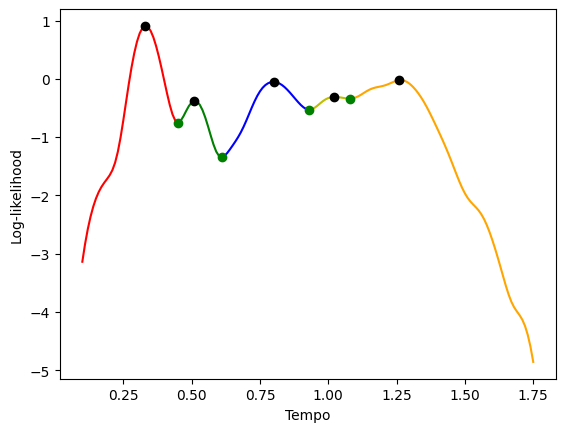

In [8]:
# Plot segments of the KDE curve between each pair of local minima (mi) using different colors

plot(s[:mi[0]+1], e[:mi[0]+1], 'r')
plot(s[mi[0]:mi[1]+1], e[mi[0]:mi[1]+1], 'g')
plot(s[mi[1]:mi[2]+1], e[mi[1]:mi[2]+1], 'b')
plot(s[mi[2]:mi[3]+1], e[mi[2]:mi[3]+1], 'y')
plot(s[mi[3]:], e[mi[3]:], 'orange')
plot(s[ma], e[ma], 'ko')
plot(s[mi], e[mi], 'go')

plt.ylabel("Log-likelihood")
plt.xlabel("Tempo")
plt.show()

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tempo_clustering(intervals, all_tempos):
    # Define the intervals based on the KDE minima positions
    # These intervals span from the minimum tempo value (0.1) to the maximum (1.75),
    # with each interval boundary set at a local minimum of the KDE curve.
    intervals = [0.1, *intervals, 1.75]

    plt.figure()
    # Define colors for each interval to match the KDE segmentation
    colors = ['red', 'green', 'blue', 'yellow', 'orange', 'violet', 'brown', 'pink']

    # Plot a histogram for each interval with a different color
    for i in range(len(intervals) - 1):
        # Filter all tempos to include only data points within the current interval
        interval_data = [tempo for tempo in all_tempos if intervals[i] <= tempo < intervals[i + 1]]
        plt.hist(interval_data, bins=100, color=colors[i], alpha=0.7, label=f"{intervals[i]:.2f} - {intervals[i+1]:.2f}")

    plt.ylabel('Counts')
    plt.xlabel('Data')
    plt.legend(title="Tempo Intervals")
    plt.show()

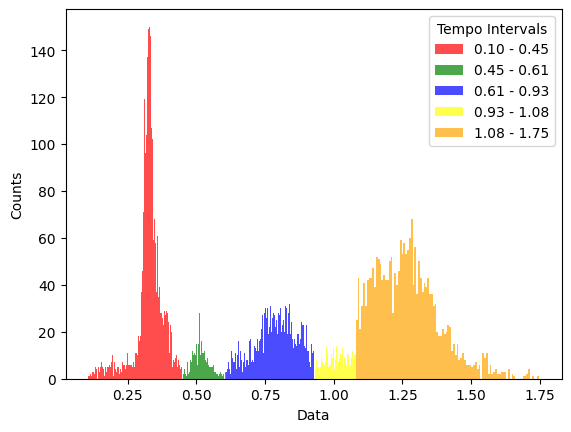

In [10]:
# Define the intervals based on the KDE minima positions
# These intervals span from the minimum tempo value (0.1) to the maximum (1.75),
# with each interval boundary set at a local minimum of the KDE curve.
intervals = [s[mi[0]], s[mi[1]], s[mi[2]], s[mi[3]]]

plot_tempo_clustering(intervals, all_tempos_ec1)

In [11]:
from sklearn.mixture import GaussianMixture
import numpy as np

# Fit GMM to 1D data
data = np.array(all_tempos_ec1).reshape(-1, 1)
gmm = GaussianMixture(n_components=5, random_state=0).fit(data)

# Extract and sort cluster centers
centers = np.sort(gmm.means_.flatten())

# Calculate midpoints between consecutive centers to define interval boundaries
intervals = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
print("GMM interval boundaries:", intervals)

GMM interval boundaries: [np.float64(0.42199938413500915), np.float64(0.6527498902008129), np.float64(0.932810434863246), np.float64(1.182865087359393)]


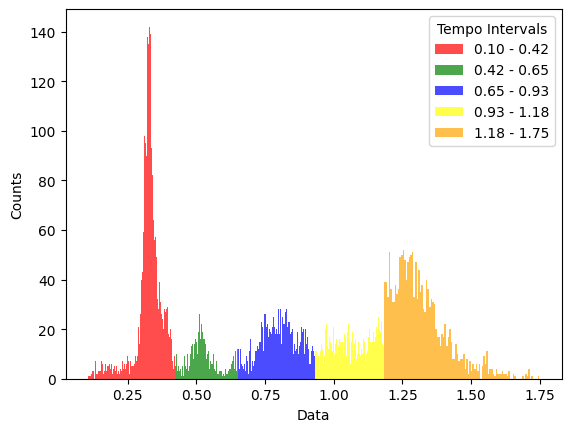

In [12]:
plot_tempo_clustering(intervals, all_tempos_ec1)

In [13]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

# Fit Agglomerative Clustering on 1D data
agg_clustering = AgglomerativeClustering(n_clusters=5)
labels = agg_clustering.fit_predict(data)

# Calculate the mean of each cluster
centers = np.array([data[labels == i].mean() for i in range(5)])
centers.sort()

# Calculate midpoints between consecutive centers to define intervals
intervals = [(centers[i] + centers[i+1]) / 2 for i in range(len(centers) - 1)]
print("Agglomerative interval boundaries:", intervals)


Agglomerative interval boundaries: [np.float64(0.4235497942601019), np.float64(0.6618966956953991), np.float64(0.9164644387082277), np.float64(1.1522860392244383)]


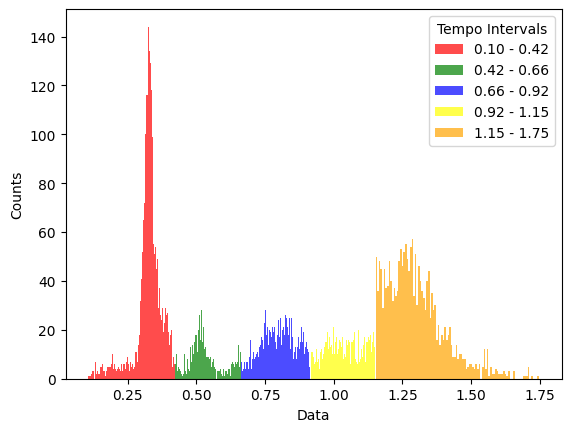

In [14]:
plot_tempo_clustering(intervals, all_tempos_ec1)

# Rhythm Analysis

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import IPython

import numpy as np
import os
from IPython.display import Image as Image2
from numpy import genfromtxt 
import pickle
from IPython import embed
from PIL import Image, ImageDraw, ImageFont 

import seaborn as sn
import pandas as pd
%matplotlib inline
from scipy import ndimage
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import matplotlib.patches as mpatches
from collections import Counter

In [5]:
my_data = genfromtxt(file_path, delimiter=',',dtype=None,encoding="utf8")
my_data[0,:]

array(['\ufeffcodaNUM2018', 'Date', 'nClicks', 'Duration', 'ICI1', 'ICI2',
       'ICI3', 'ICI4', 'ICI5', 'ICI6', 'ICI7', 'ICI8', 'ICI9', 'CodaType',
       'Clan', 'Unit', 'UnitNum', 'IDN'], dtype='<U12')

In [6]:
c_types = []

for i in range(1,my_data.shape[0]):
    curr_clan = my_data[i,-4]
    
    if curr_clan=="EC1":
        c_types.append(my_data[i,-5])

In [7]:
Counter(c_types)

Counter({np.str_('1+1+3'): 3574,
         np.str_('5R1'): 1510,
         np.str_('4R2'): 303,
         np.str_('5R2'): 287,
         np.str_('5-NOISE'): 227,
         np.str_('4D'): 219,
         np.str_('6i'): 182,
         np.str_('8i'): 178,
         np.str_('7D1'): 171,
         np.str_('6-NOISE'): 167,
         np.str_('7i'): 145,
         np.str_('9i'): 135,
         np.str_('4R1'): 82,
         np.str_('2+3'): 77,
         np.str_('1+32'): 71,
         np.str_('3D'): 61,
         np.str_('10i'): 52,
         np.str_('1+31'): 51,
         np.str_('8R'): 41,
         np.str_('4-NOISE'): 38,
         np.str_('7D2'): 35,
         np.str_('3R'): 21,
         np.str_('9R'): 20,
         np.str_('8D'): 20,
         np.str_('5R3'): 19,
         np.str_('9-NOISE'): 14,
         np.str_('3-NOISE'): 13,
         np.str_('10R'): 11,
         np.str_('8-NOISE'): 10,
         np.str_('7-NOISE'): 10,
         np.str_('10-NOISE'): 9,
         np.str_('1-NOISE'): 8,
         np.str_('2-NOISE'): 

In [8]:
rhythm = {'1+1+3':5,
 '1+31':4,
 '1+32':4,
 '1-NOISE':-1,
 '10-NOISE':-2,
 '10R':16,
 '10i':17,
 '2+3':7,
 '2-NOISE':-3,
 '3-NOISE':-4,
 '3D':0,
 '3R':1,
 '4-NOISE':-5,
 '4D':2,
 '4R1':3,
 '4R2':3,
 '5-NOISE':-6,
 '5R1':6,
 '5R2':6,
 '5R3':6,
 '6-NOISE':-7,
 '6R':8,
 '6i':9,
 '7-NOISE':-8,
 '7D1':10,
 '7D2':10,
 '7i':11,
 '8-NOISE':-9,
 '8D':12,
 '8R':12,
 '8i':13,
 '9-NOISE':-10,
 '9R':14,
 '9i':15}

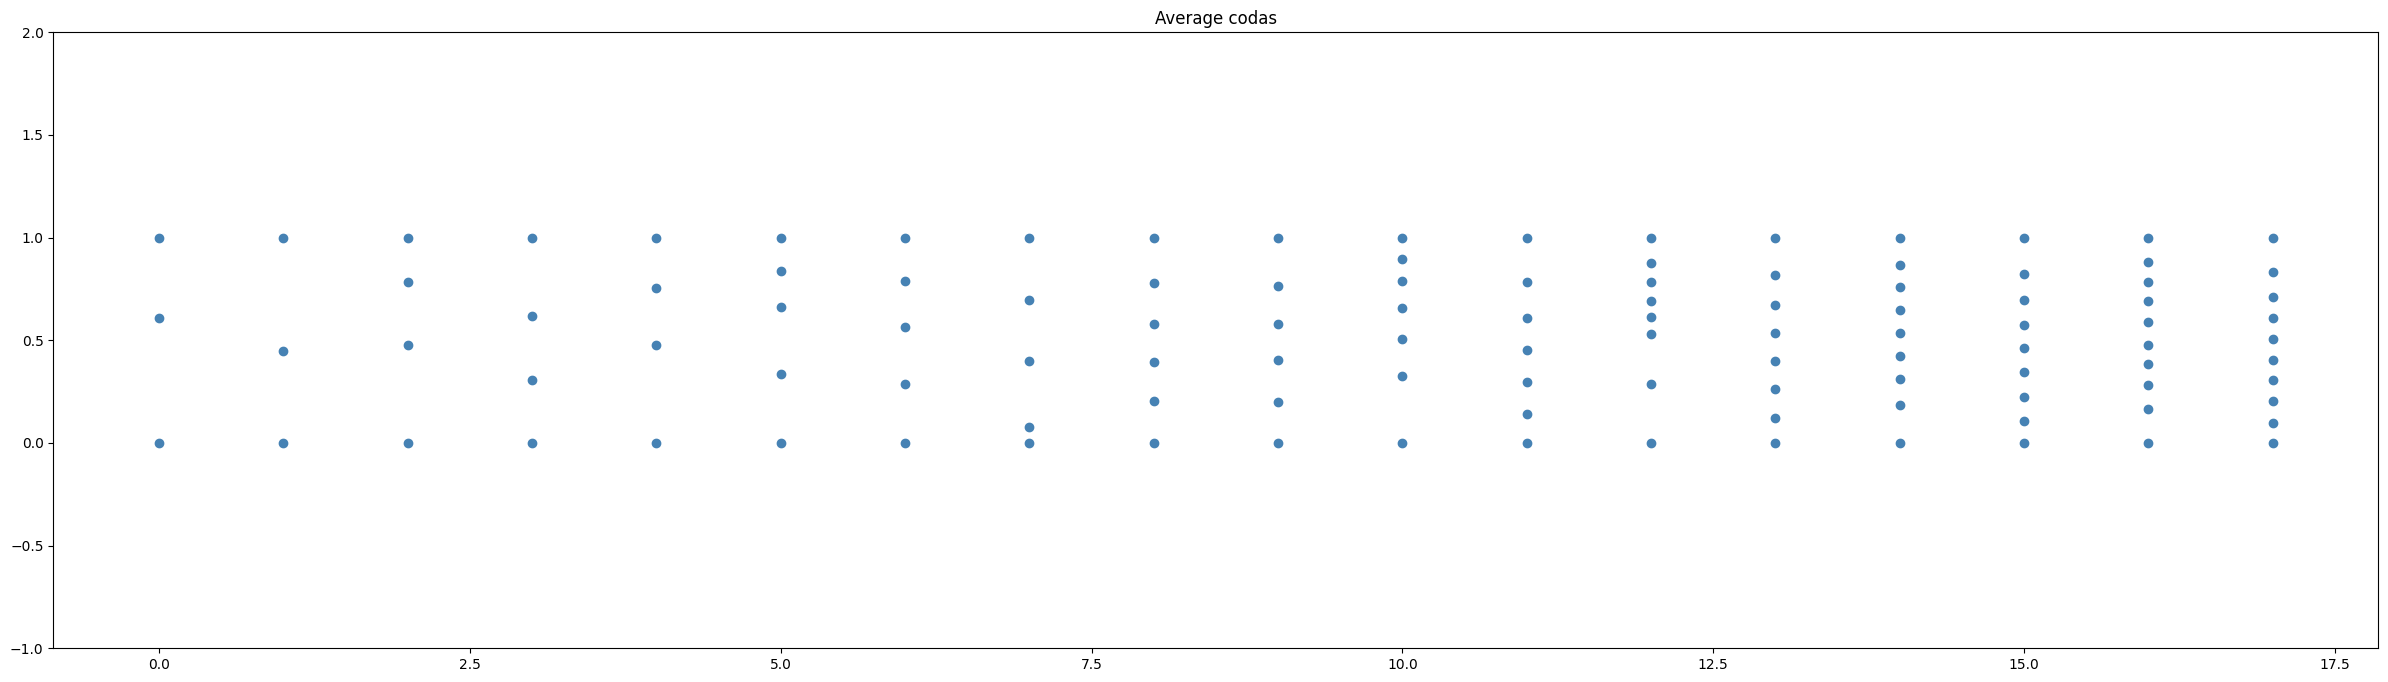

In [9]:
all_rhythms = []
mean_codas = []
all_types = set(c_types)
def return_relative(idx):
    n_clicks = my_data[idx,2].astype(int)
    rel_ICI = []
    rel_ICI.append(0)
    for t in range(5,4+n_clicks):
        rel_ICI.append(np.sum(my_data[idx,4:t].astype(float)))
    return rel_ICI

fig = plt.figure(figsize=(30, 8))
for ctype in all_types:
    rhy = rhythm[ctype]
#     print(ctype,rhy)
    if rhy>-1 and rhy not in all_rhythms:
        all_rhythms.append(rhy)
        relative_ICI_vect = []
        for i in range(1,my_data.shape[0]):
            curr_clan = my_data[i,-4]
            if curr_clan=="EC1" and my_data[i,-5]==ctype:
                if max(return_relative(i))!=0:
                    relative_ICIs = return_relative(i)/max(return_relative(i))
                    if len(relative_ICI_vect)==0 or len(relative_ICI_vect[-1])==len(relative_ICIs):
                        relative_ICI_vect.append(relative_ICIs)
                        x = len(relative_ICIs)*[rhy]
#         print(len(x),len(np.mean(np.array(relative_ICI_vect),0)))
        plt.scatter(x,np.mean(np.array(relative_ICI_vect),0),color='steelblue')
        mean_codas.append(np.mean(np.array(relative_ICI_vect),0))
plt.ylim(-1,2)
plt.title('Average codas')
plt.show()

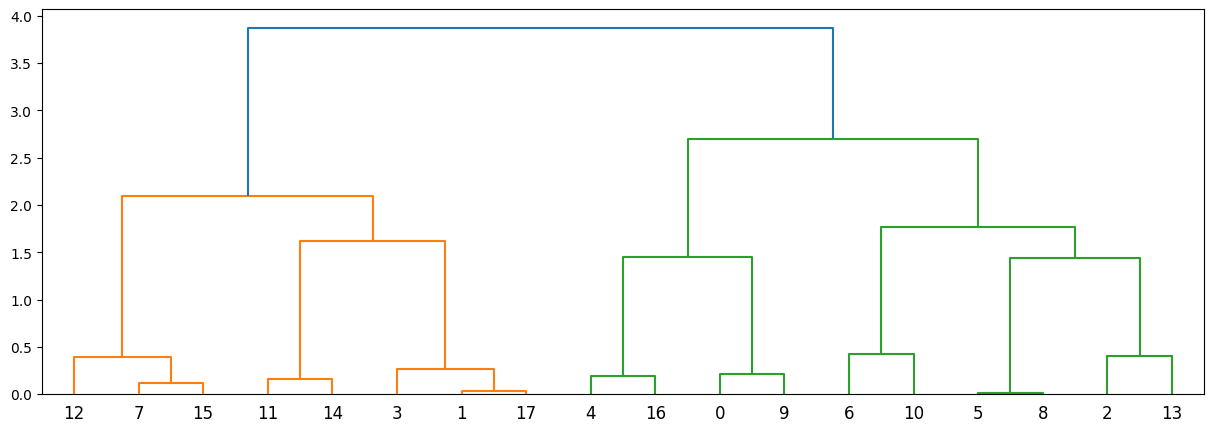

In [10]:
# Plot the dendrogram visualization of the codas

import scipy.cluster.hierarchy as sch

new_codas = []

for i in range(len(mean_codas)):
    new_codas.append(list(mean_codas[i])+(10-len(mean_codas[i]))*[0])
    
X = np.array(new_codas)
Z = sch.linkage(X, method='ward')
fig = plt.figure(figsize=(15, 5))
dn = sch.dendrogram(Z,)
# plt.show()

In [21]:
my_data

array([['\ufeffcodaNUM2018', 'Date', 'nClicks', ..., 'Unit', 'UnitNum',
        'IDN'],
       ['1', '04/03/2005', '5', ..., 'A', '1', '0'],
       ['2', '04/03/2005', '5', ..., 'A', '1', '0'],
       ...,
       ['8876', '13-05-2016', '5', ..., 'J', '4', '0'],
       ['8877', '13-05-2016', '5', ..., 'J', '4', '0'],
       ['8878', '13-05-2016', '5', ..., 'J', '4', '0']], dtype='<U12')

CodaClass    3-NOISE         3D         3R
Cluster                                   
0           3.636364  94.545455   1.818182
1          39.583333  18.750000  41.666667
CodaClass
3D         61
3-NOISE    21
3R         21
Name: count, dtype: int64


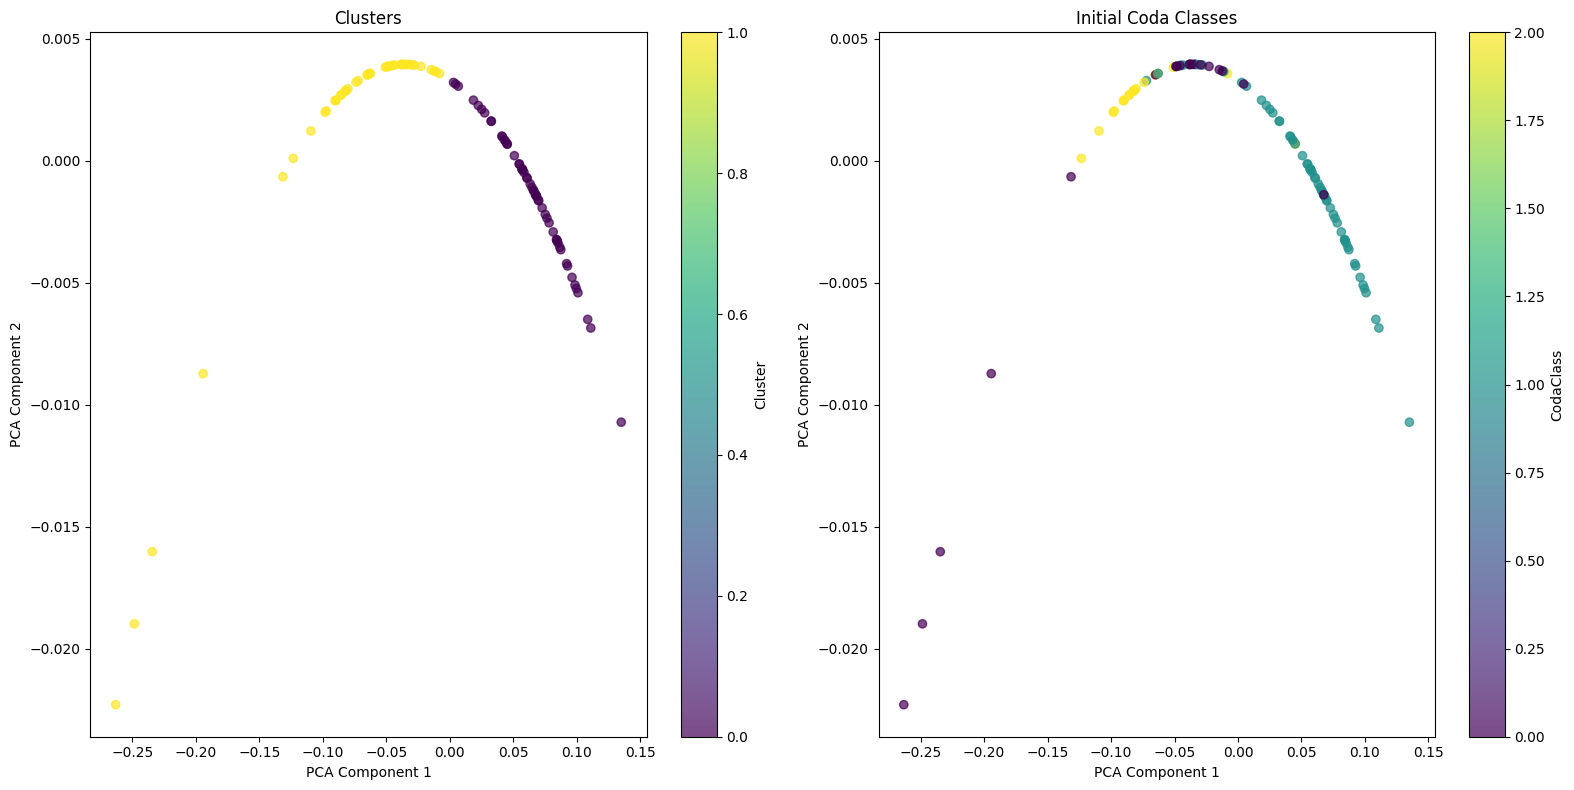

CodaClass     3-NOISE         3D         3R
Cluster                                    
0            3.636364  94.545455   1.818182
1          100.000000   0.000000   0.000000
2           34.090909  20.454545  45.454545
CodaClass
3D         61
3-NOISE    21
3R         21
Name: count, dtype: int64


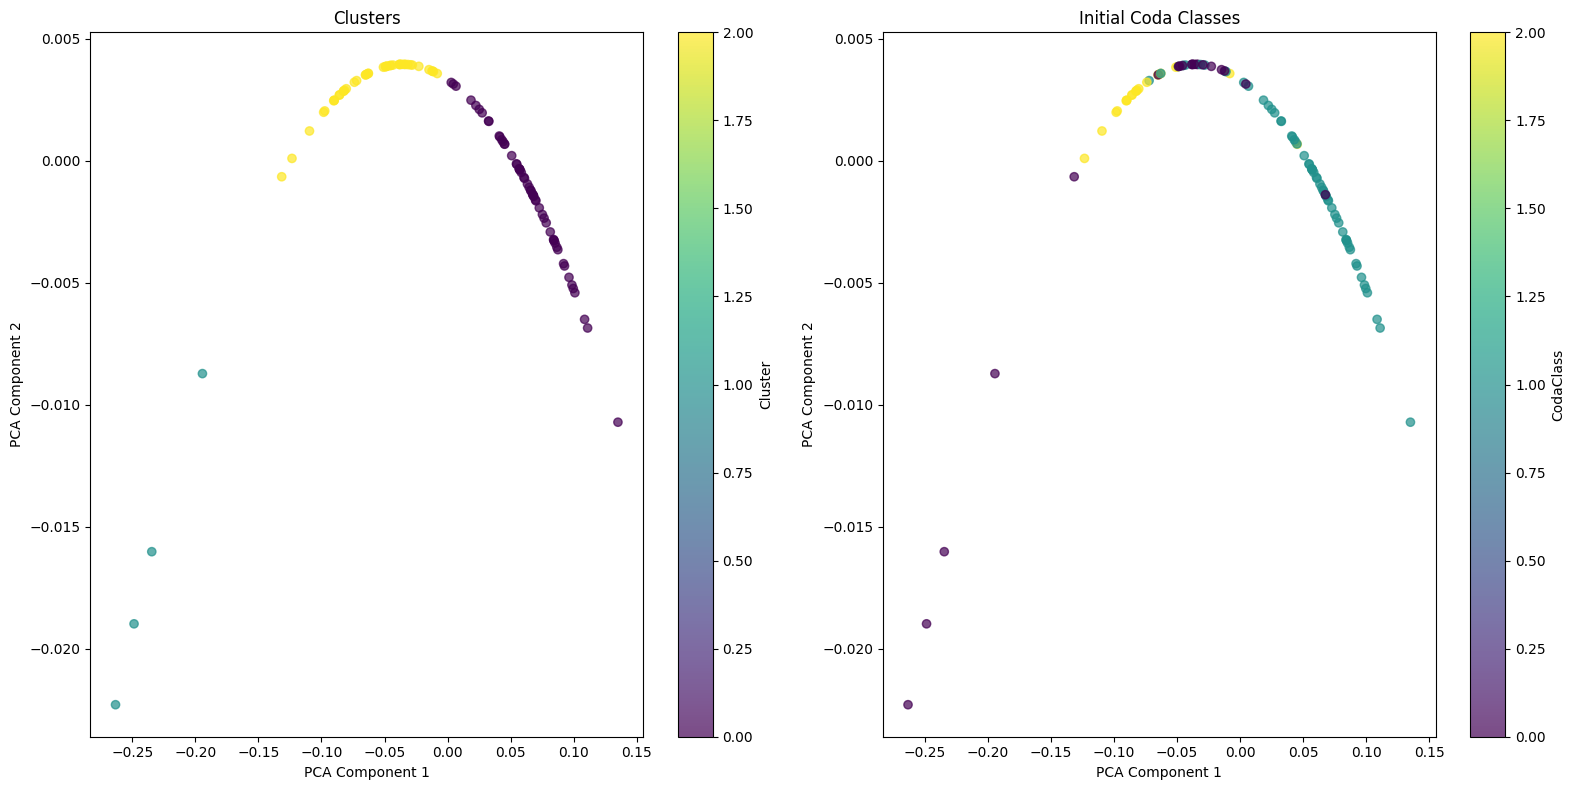

CodaClass     3-NOISE         3D         3R
Cluster                                    
0            1.960784  96.078431   1.960784
1          100.000000   0.000000   0.000000
2            9.523810   9.523810  80.952381
3           51.851852  37.037037  11.111111
CodaClass
3D         61
3-NOISE    21
3R         21
Name: count, dtype: int64


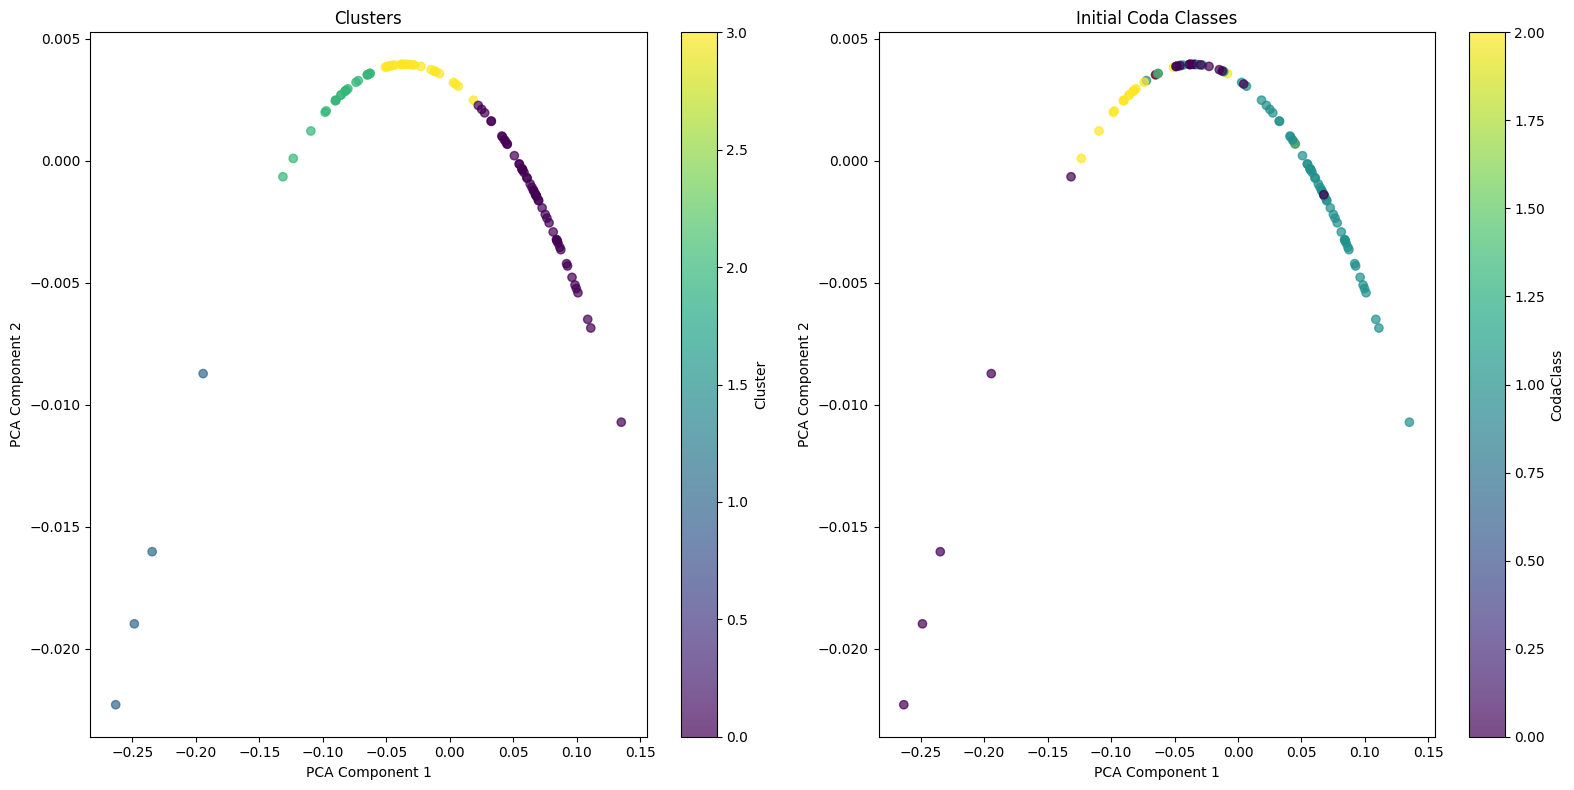

CodaClass     3-NOISE         3D         3R
Cluster                                    
0            2.173913  95.652174   2.173913
1          100.000000   0.000000   0.000000
2            6.250000   6.250000  87.500000
3           52.173913  26.086957  21.739130
4           21.428571  71.428571   7.142857
CodaClass
3D         61
3-NOISE    21
3R         21
Name: count, dtype: int64


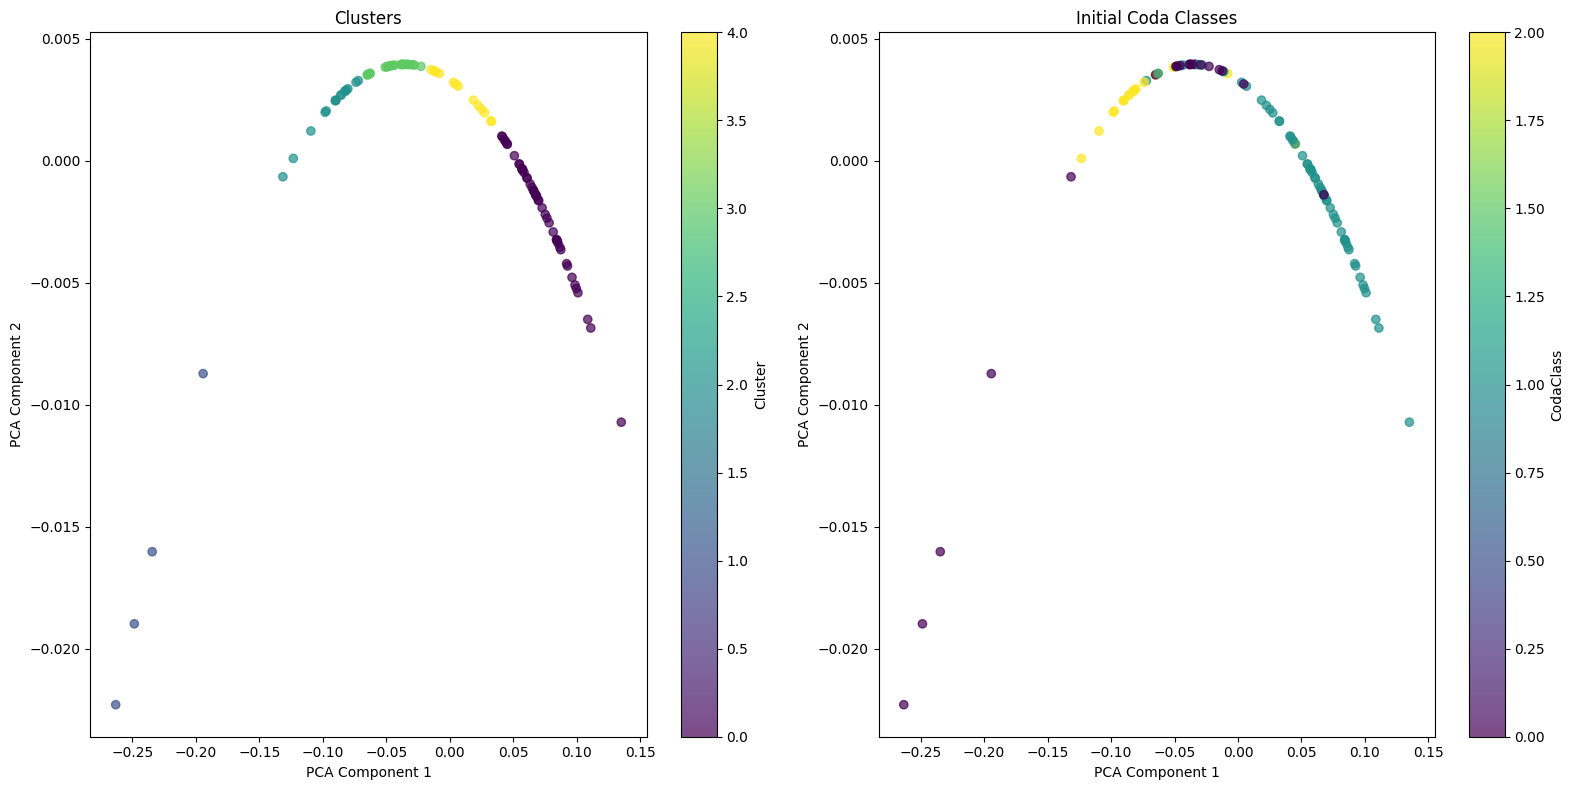

CodaClass     3-NOISE          3D         3R
Cluster                                     
0            3.333333   93.333333   3.333333
1          100.000000    0.000000   0.000000
2            6.250000    6.250000  87.500000
3           52.173913   26.086957  21.739130
4           25.000000   66.666667   8.333333
5            0.000000  100.000000   0.000000
CodaClass
3D         61
3-NOISE    21
3R         21
Name: count, dtype: int64


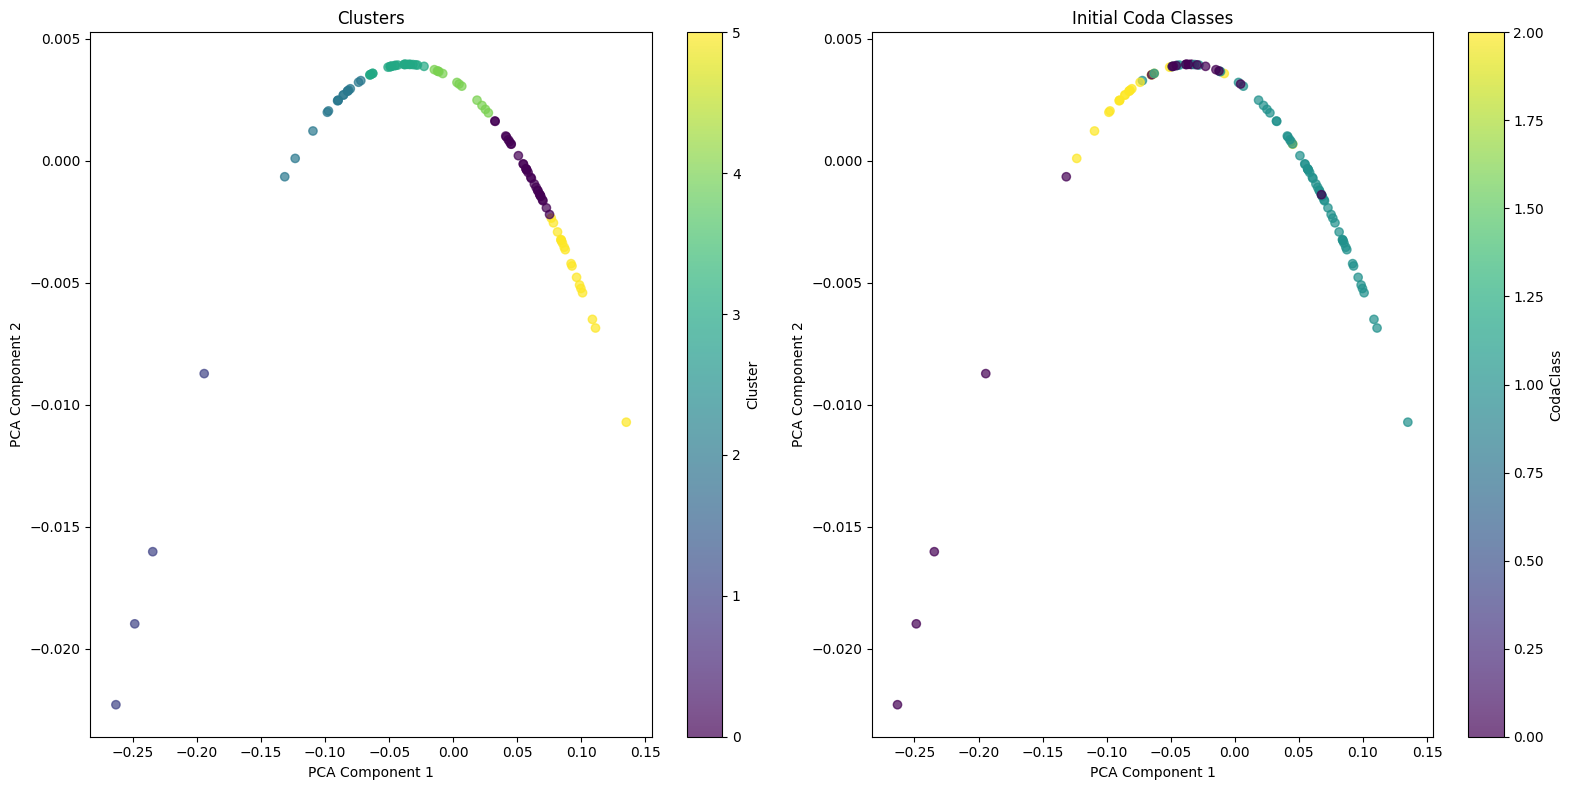

CodaClass       1+31       1+32   4-NOISE         4D        4R1        4R2  \
Cluster                                                                      
0          11.325967  19.889503  6.906077  59.944751   1.933702   0.000000   
1           2.192982   0.000000  5.701754   0.438596  16.885965  74.561404   

CodaClass   5-NOISE  
Cluster              
0          0.000000  
1          0.219298  
CodaClass
4R2        340
4D         219
4R1         84
1+32        72
4-NOISE     51
1+31        51
5-NOISE      1
Name: count, dtype: int64


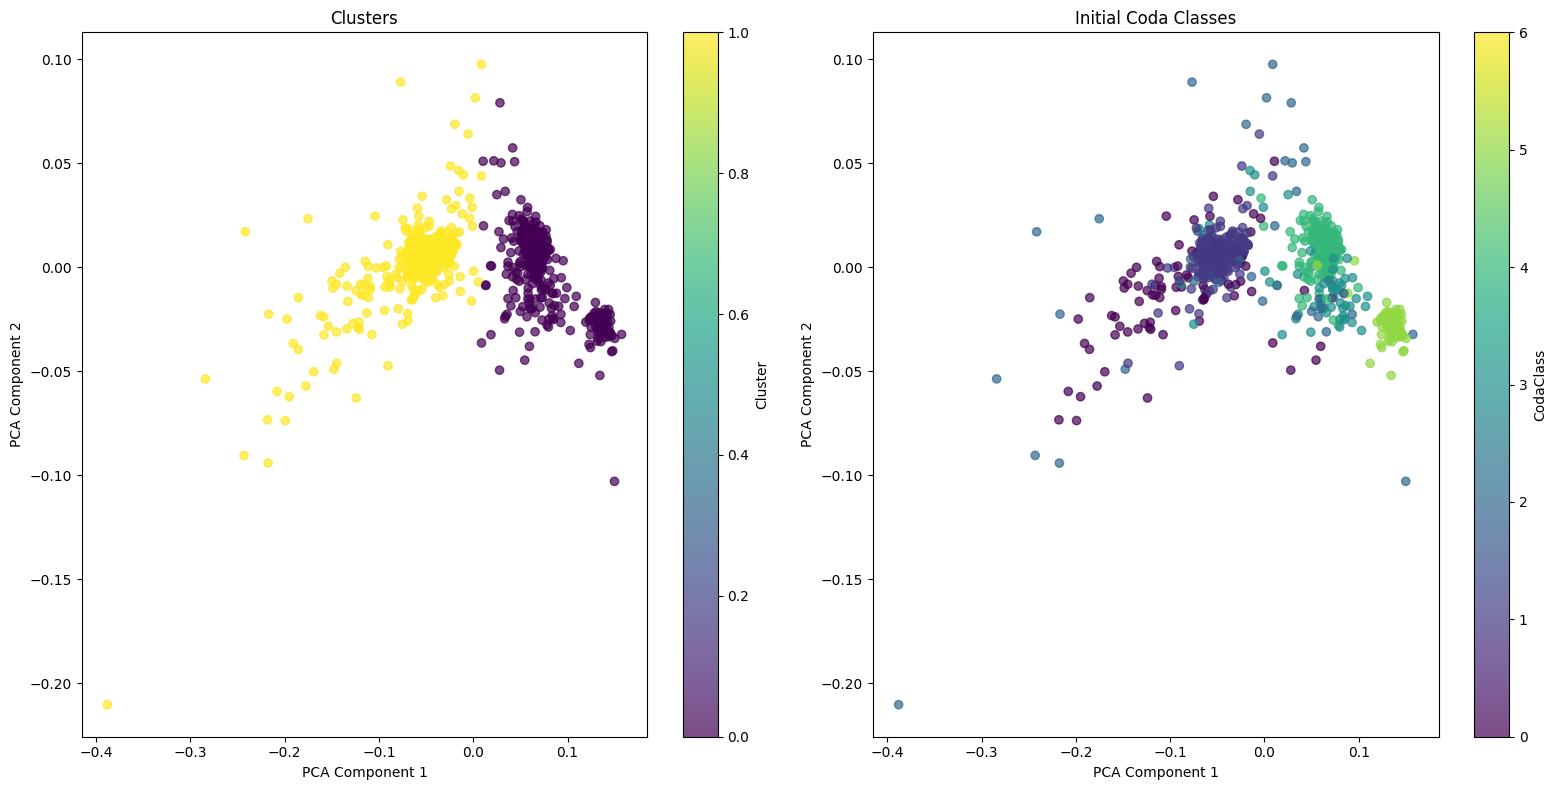

CodaClass       1+31       1+32    4-NOISE         4D       4R1        4R2  \
Cluster                                                                      
0          11.484594  20.168067   6.442577  60.504202   1.40056   0.000000   
1           2.433090   0.000000   4.866180   0.729927   9.73236  81.995134   
2           0.000000   0.000000  16.000000   0.000000  78.00000   6.000000   

CodaClass   5-NOISE  
Cluster              
0          0.000000  
1          0.243309  
2          0.000000  
CodaClass
4R2        340
4D         219
4R1         84
1+32        72
4-NOISE     51
1+31        51
5-NOISE      1
Name: count, dtype: int64


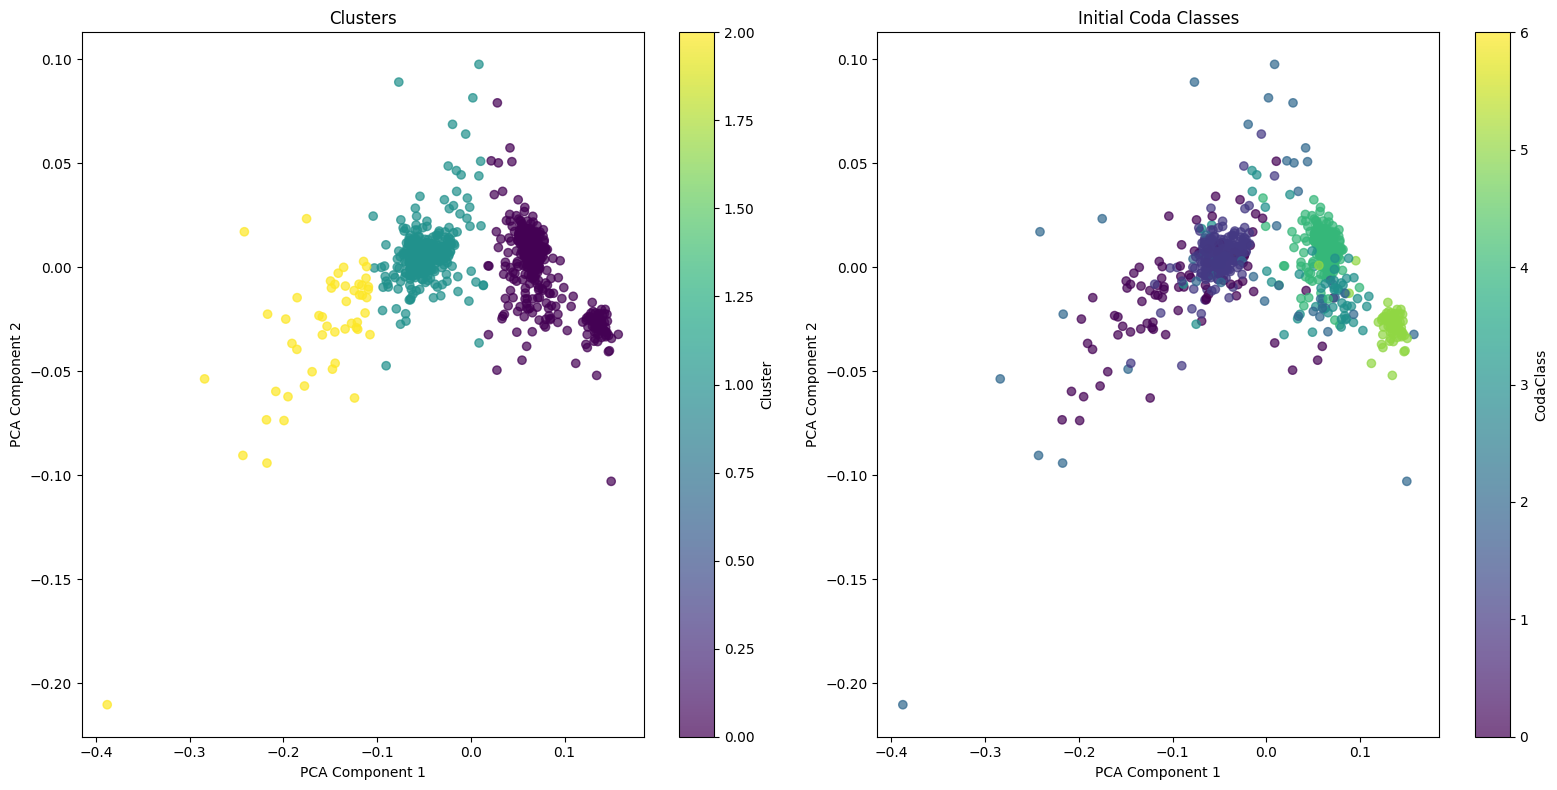

CodaClass       1+31       1+32    4-NOISE         4D        4R1        4R2  \
Cluster                                                                       
0          12.587413   1.048951   8.041958  75.524476   2.447552   0.349650   
1           2.475248   0.000000   4.207921   0.495050   9.405941  83.168317   
2           0.000000   0.000000  16.000000   0.000000  78.000000   6.000000   
3           6.410256  88.461538   3.846154   1.282051   0.000000   0.000000   

CodaClass   5-NOISE  
Cluster              
0          0.000000  
1          0.247525  
2          0.000000  
3          0.000000  
CodaClass
4R2        340
4D         219
4R1         84
1+32        72
4-NOISE     51
1+31        51
5-NOISE      1
Name: count, dtype: int64


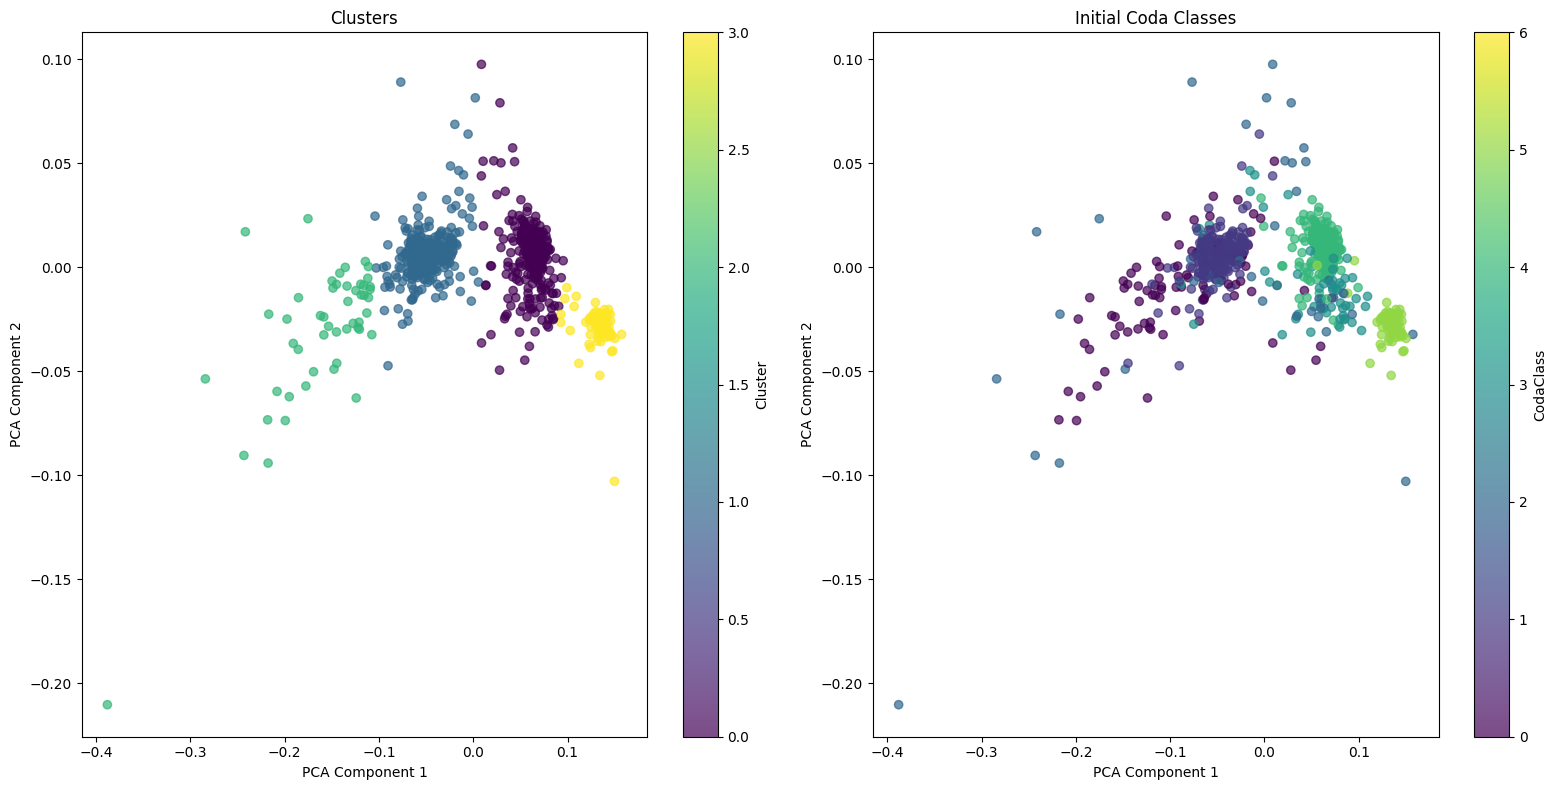

CodaClass       1+31       1+32     4-NOISE         4D        4R1        4R2  \
Cluster                                                                        
0          12.587413   1.048951    8.041958  75.524476   2.447552   0.349650   
1           2.475248   0.000000    4.207921   0.495050   9.405941  83.168317   
2           0.000000   0.000000   14.285714   0.000000  79.591837   6.122449   
3           6.410256  88.461538    3.846154   1.282051   0.000000   0.000000   
4           0.000000   0.000000  100.000000   0.000000   0.000000   0.000000   

CodaClass   5-NOISE  
Cluster              
0          0.000000  
1          0.247525  
2          0.000000  
3          0.000000  
4          0.000000  
CodaClass
4R2        340
4D         219
4R1         84
1+32        72
4-NOISE     51
1+31        51
5-NOISE      1
Name: count, dtype: int64


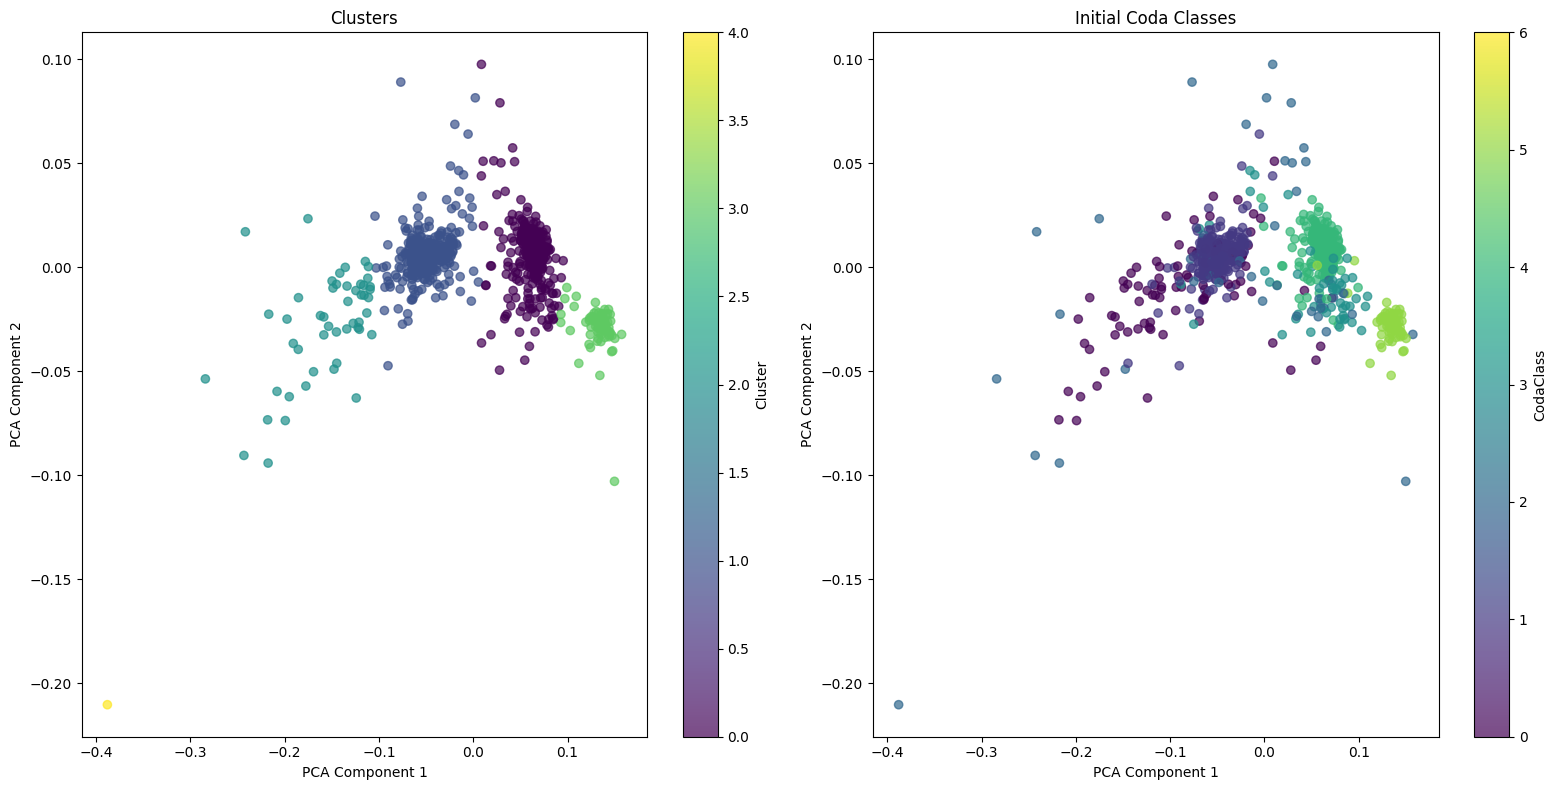

CodaClass       1+31       1+32     4-NOISE         4D        4R1        4R2  \
Cluster                                                                        
0          37.500000   2.272727   17.045455  36.363636   6.818182   0.000000   
1           2.481390   0.000000    3.970223   0.496278   9.429280  83.374690   
2           0.000000   0.000000   14.285714   0.000000  79.591837   6.122449   
3           4.054054  93.243243    2.702703   0.000000   0.000000   0.000000   
4           0.000000   0.000000  100.000000   0.000000   0.000000   0.000000   
5           2.463054   0.492611    4.926108  91.133005   0.492611   0.492611   

CodaClass   5-NOISE  
Cluster              
0          0.000000  
1          0.248139  
2          0.000000  
3          0.000000  
4          0.000000  
5          0.000000  
CodaClass
4R2        340
4D         219
4R1         84
1+32        72
4-NOISE     51
1+31        51
5-NOISE      1
Name: count, dtype: int64


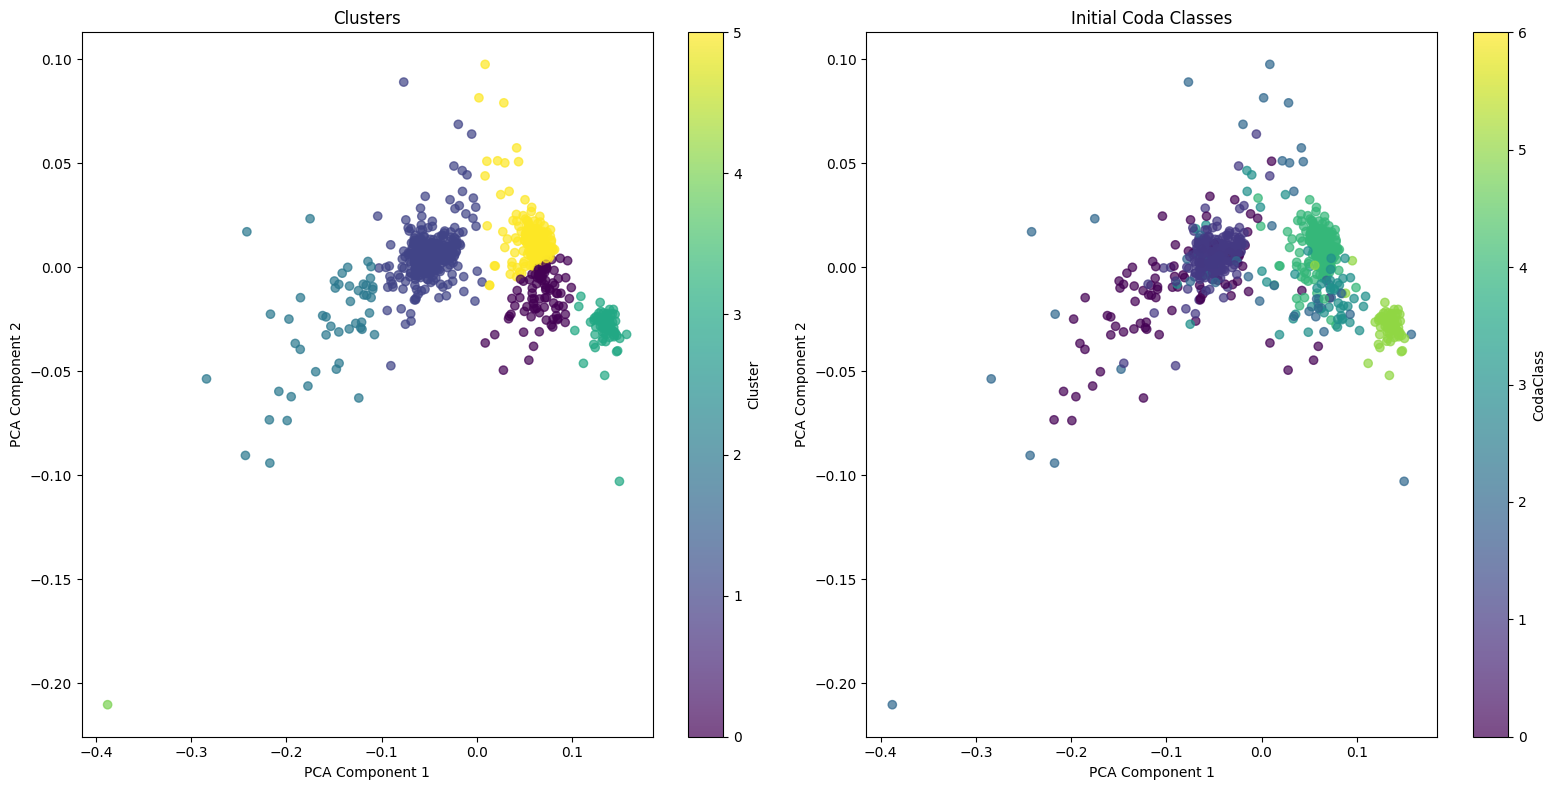

CodaClass      1+1+3       2+3   5-NOISE        5R1        5R2        5R3  \
Cluster                                                                     
0           2.580071  3.425267  7.606762  45.017794  12.766904  28.558719   
1          85.372340  0.000000  2.587041  12.040619   0.000000   0.000000   

CodaClass   6-NOISE  
Cluster              
0          0.044484  
1          0.000000  
CodaClass
1+1+3      3589
5R1        1510
5R3         642
5R2         287
5-NOISE     278
2+3          77
6-NOISE       1
Name: count, dtype: int64


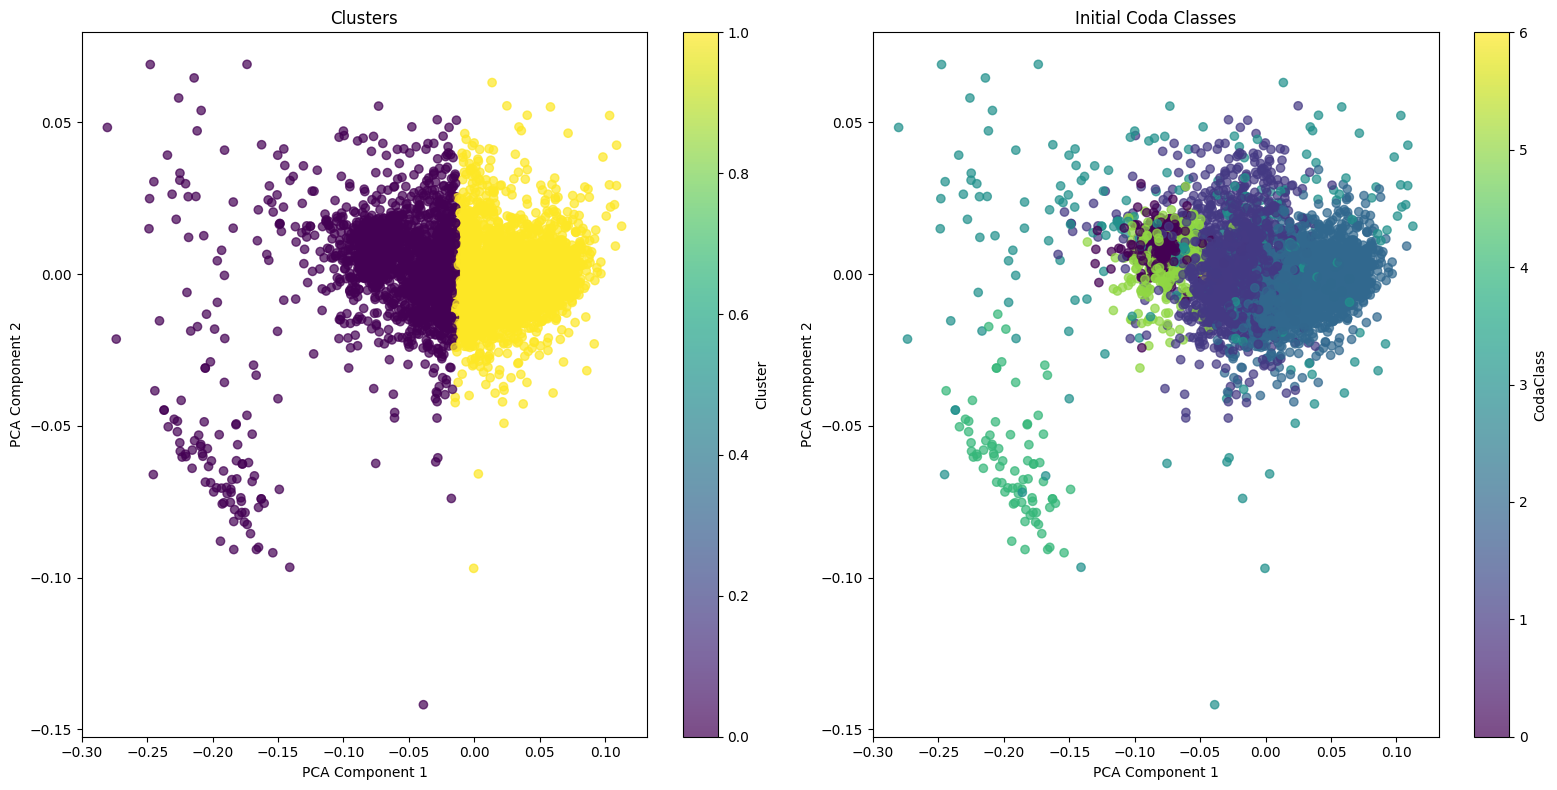

CodaClass      1+1+3       2+3   5-NOISE        5R1        5R2        5R3  \
Cluster                                                                     
0          35.180944  0.000000  4.306001  59.688502   0.458085   0.320660   
1          96.739876  0.000000  2.024708   1.235415   0.000000   0.000000   
2           0.155400  5.982906  9.712510  13.286713  21.522922  49.339549   

CodaClass   6-NOISE  
Cluster              
0          0.045809  
1          0.000000  
2          0.000000  
CodaClass
1+1+3      3589
5R1        1510
5R3         642
5R2         287
5-NOISE     278
2+3          77
6-NOISE       1
Name: count, dtype: int64


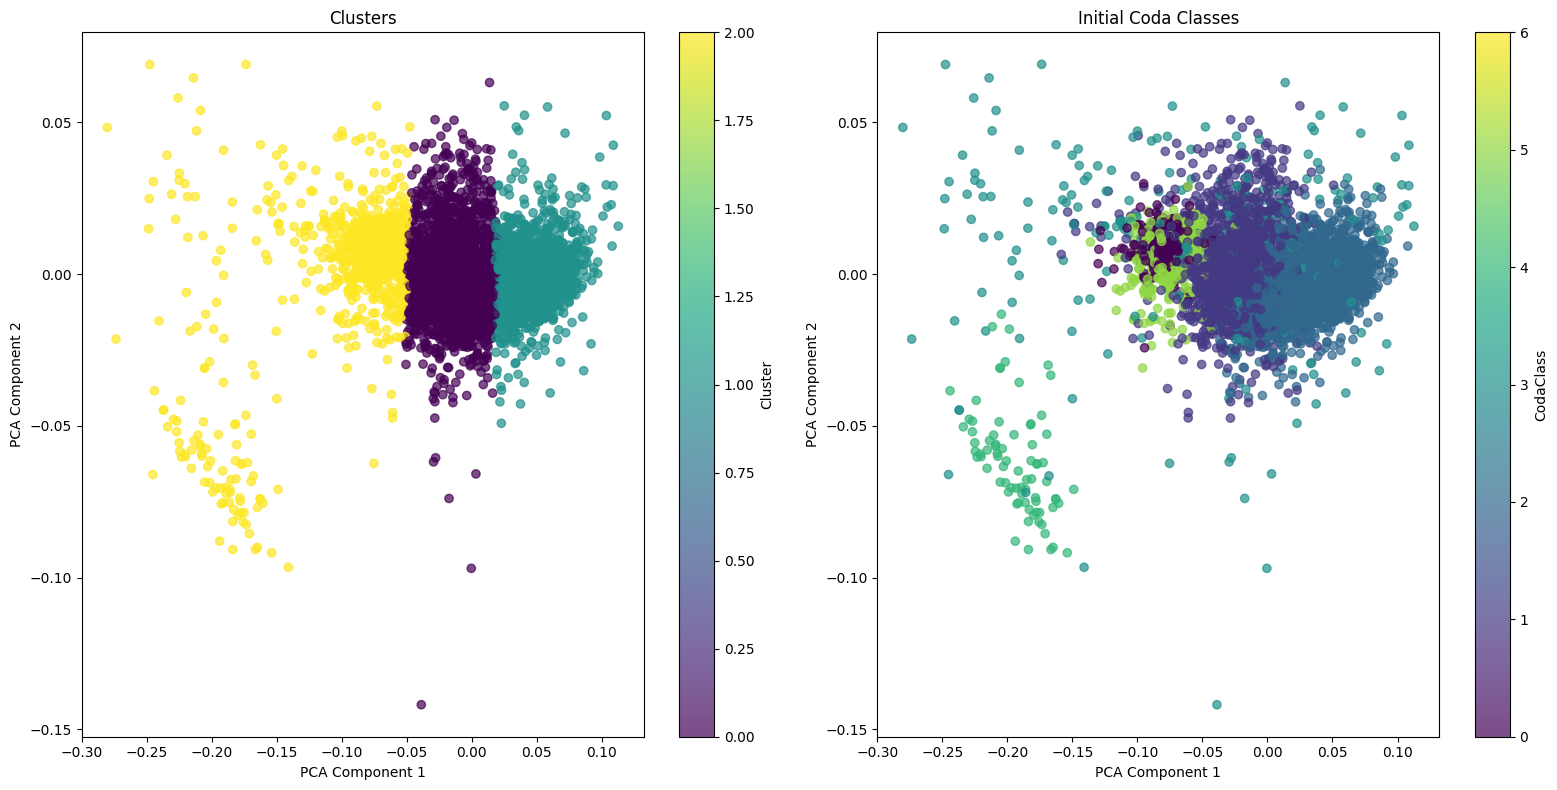

CodaClass      1+1+3        2+3    5-NOISE        5R1        5R2        5R3  \
Cluster                                                                       
0          41.359773   0.000000   4.202077  54.107649   0.188857   0.141643   
1          96.993558   0.000000   2.111668   0.894775   0.000000   0.000000   
2           0.224888   0.000000   5.547226  25.037481  21.214393  47.901049   
3           0.000000  55.797101  40.579710   3.623188   0.000000   0.000000   

CodaClass   6-NOISE  
Cluster              
0          0.000000  
1          0.000000  
2          0.074963  
3          0.000000  
CodaClass
1+1+3      3589
5R1        1510
5R3         642
5R2         287
5-NOISE     278
2+3          77
6-NOISE       1
Name: count, dtype: int64


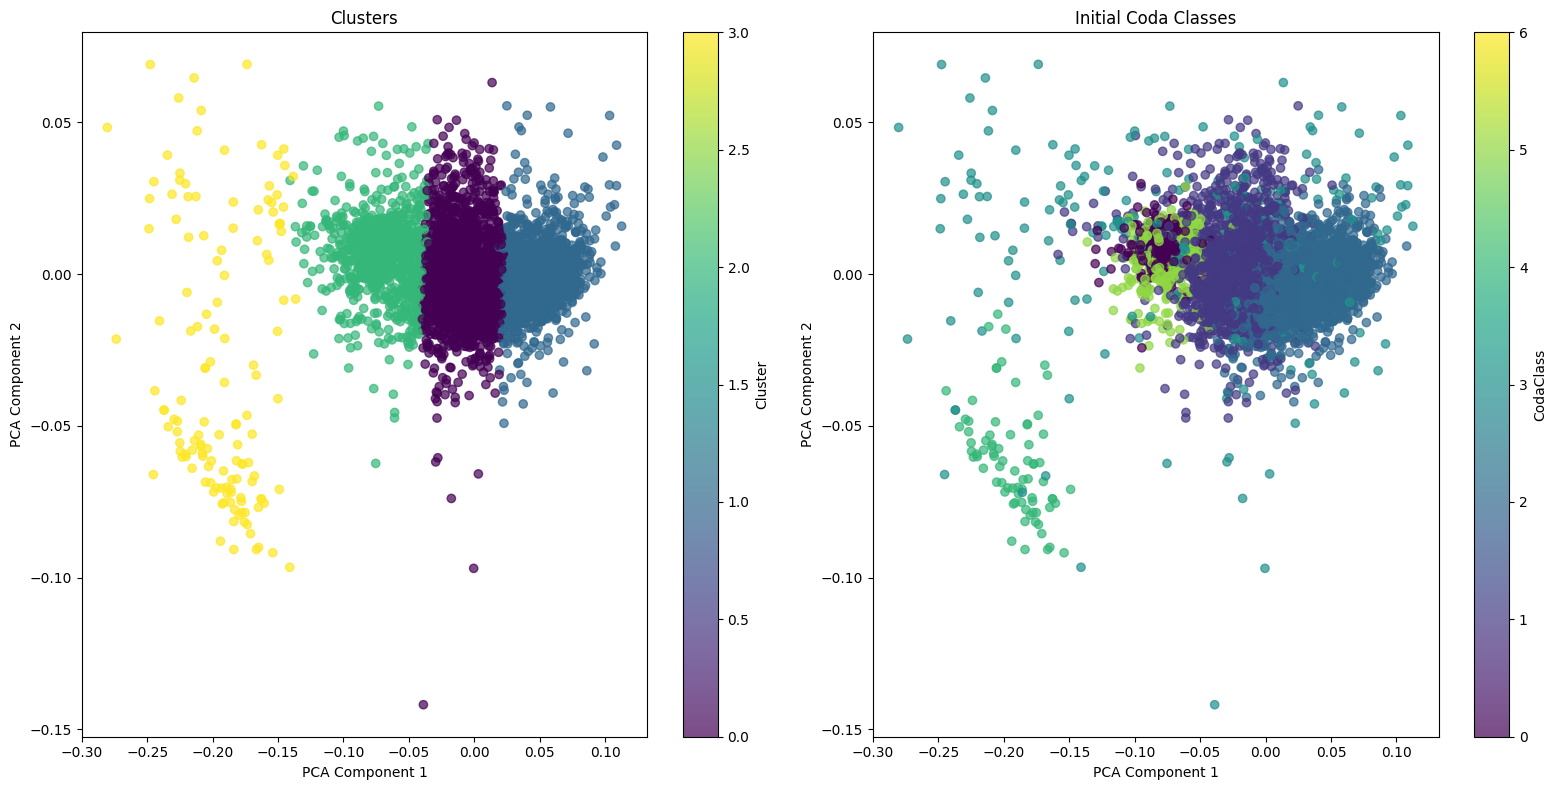

CodaClass      1+1+3        2+3    5-NOISE        5R1        5R2        5R3  \
Cluster                                                                       
0          10.668670   0.000000   5.259204  82.794891   0.676183   0.525920   
1          97.798327   0.000000   1.981506   0.220167   0.000000   0.000000   
2           0.173461   0.000000   6.331310  14.310494  24.111015  55.073721   
3           0.000000  57.462687  38.805970   3.731343   0.000000   0.000000   
4          81.872910   0.000000   2.541806  15.585284   0.000000   0.000000   

CodaClass   6-NOISE  
Cluster              
0          0.075131  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.000000  
CodaClass
1+1+3      3589
5R1        1510
5R3         642
5R2         287
5-NOISE     278
2+3          77
6-NOISE       1
Name: count, dtype: int64


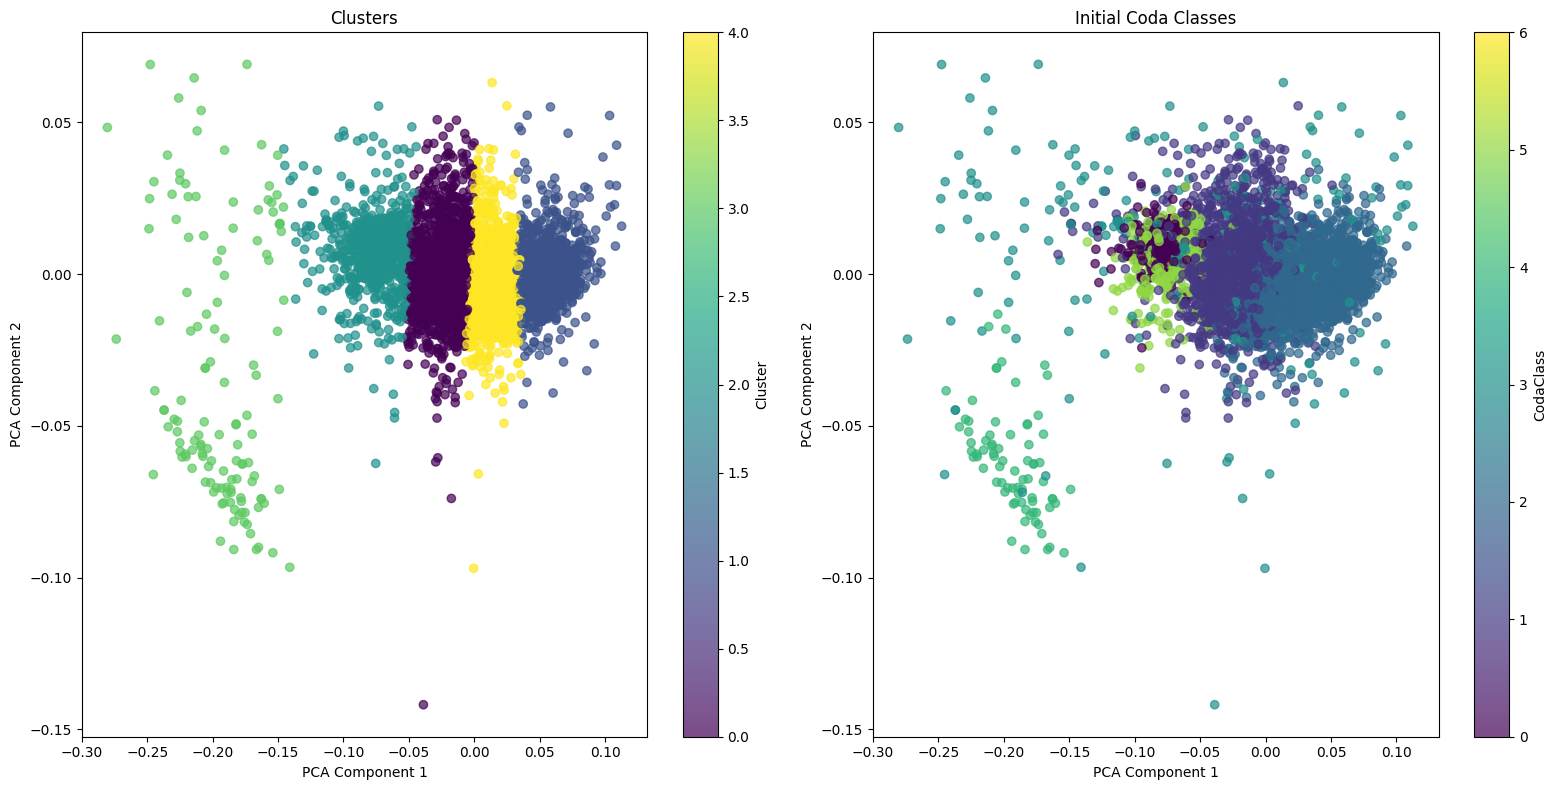

CodaClass      1+1+3        2+3    5-NOISE        5R1        5R2        5R3  \
Cluster                                                                       
0          10.708899   0.000000   5.354449  82.654600   0.678733   0.527903   
1          97.800264   0.000000   1.979762   0.219974   0.000000   0.000000   
2           0.173913   0.000000   5.826087  14.695652  24.086957  55.217391   
3           0.000000  87.209302  12.790698   0.000000   0.000000   0.000000   
4          81.903485   0.000000   2.479893  15.616622   0.000000   0.000000   
5           0.000000   3.508772  82.456140  12.280702   1.754386   0.000000   

CodaClass   6-NOISE  
Cluster              
0          0.075415  
1          0.000000  
2          0.000000  
3          0.000000  
4          0.000000  
5          0.000000  
CodaClass
1+1+3      3589
5R1        1510
5R3         642
5R2         287
5-NOISE     278
2+3          77
6-NOISE       1
Name: count, dtype: int64


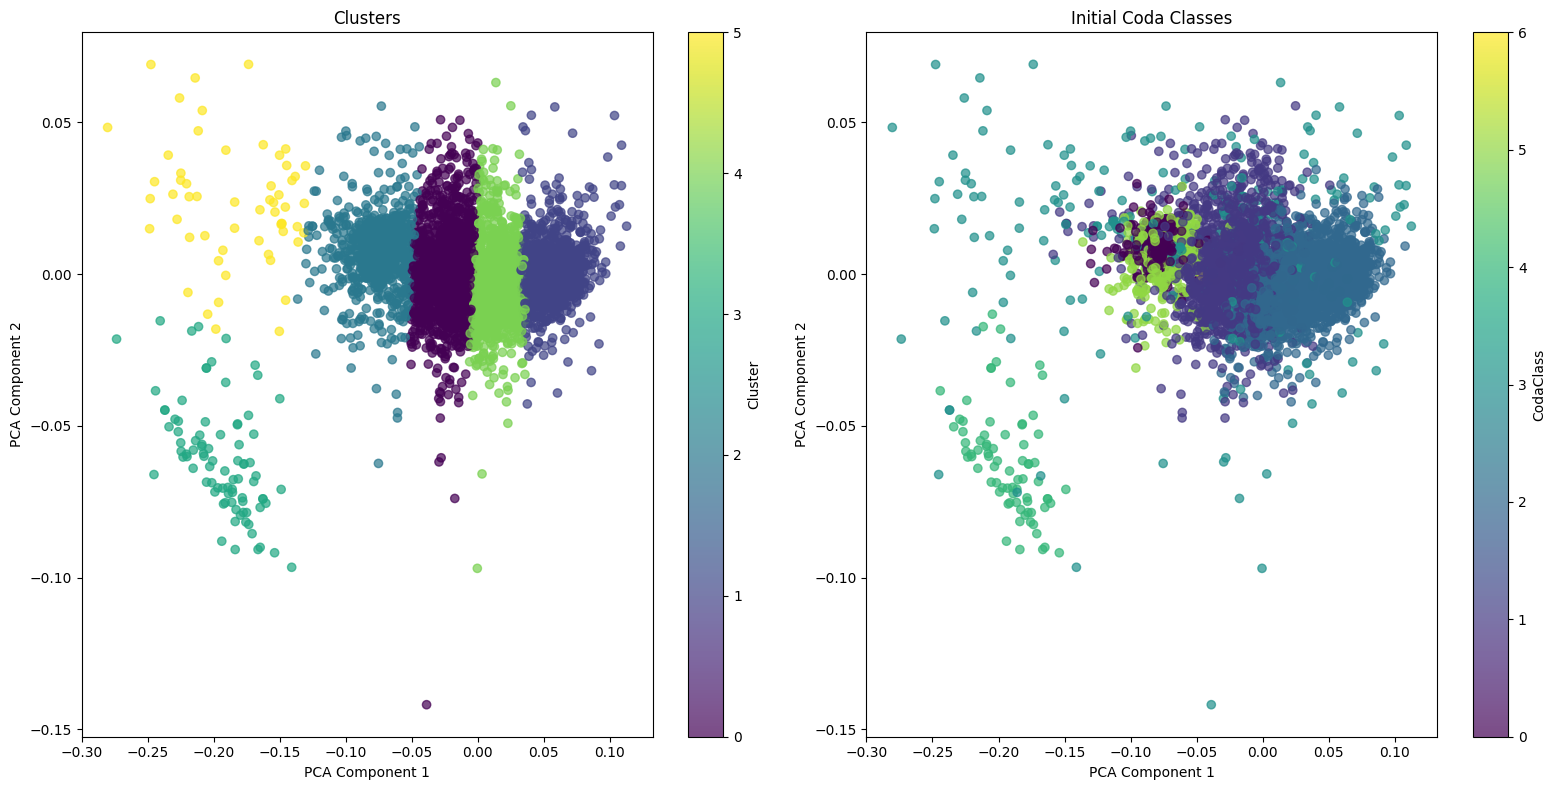

CodaClass   5-NOISE    6-NOISE         6R         6i
Cluster                                             
0          0.000000   9.302326  31.162791  59.534884
1          0.471698  71.226415   0.000000  28.301887
CodaClass
6i         188
6-NOISE    171
6R          67
5-NOISE      1
Name: count, dtype: int64


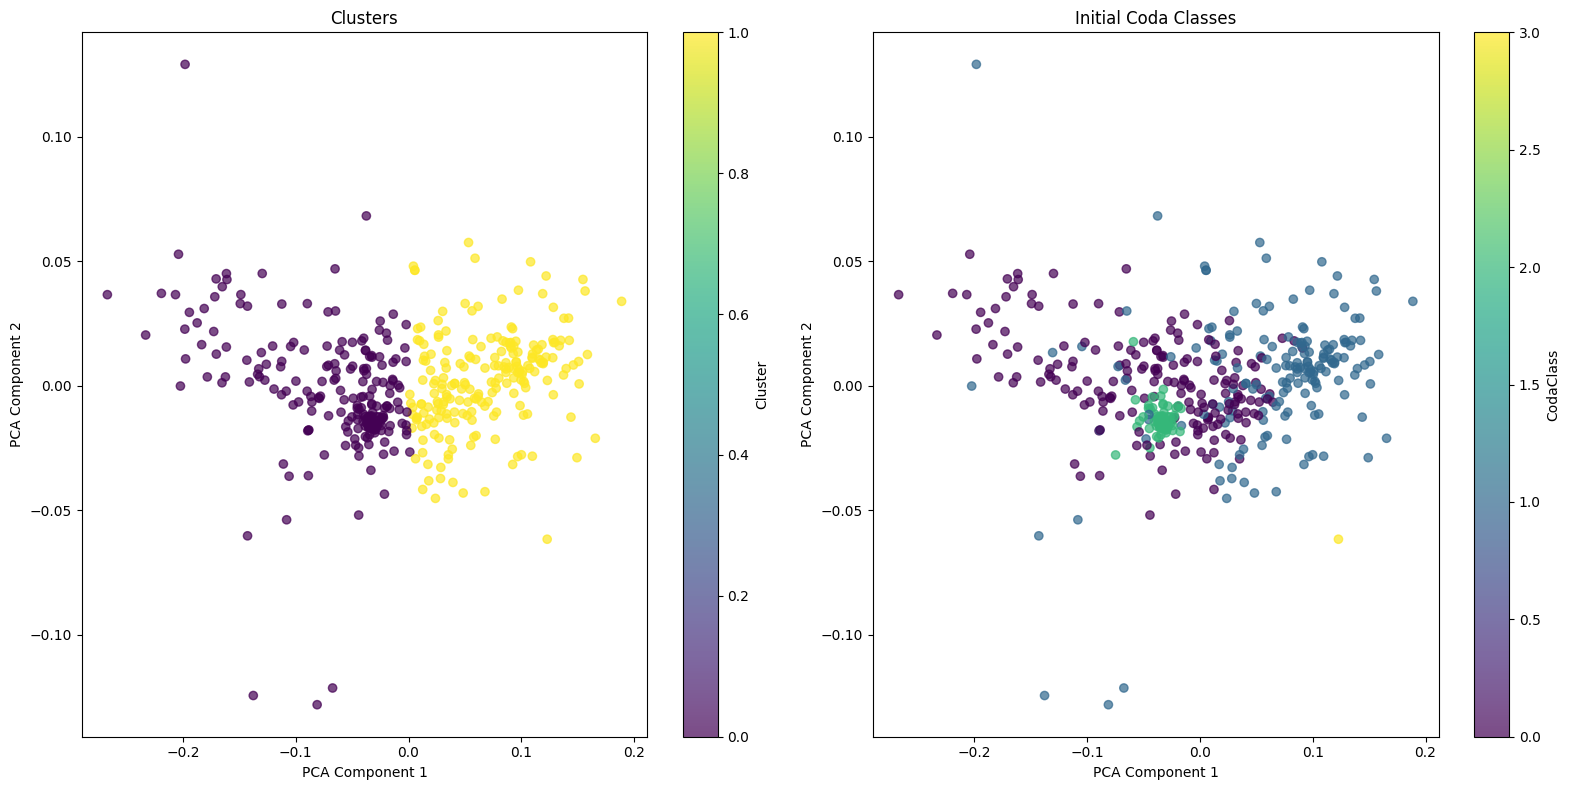

CodaClass   5-NOISE    6-NOISE         6R         6i
Cluster                                             
0          0.000000  17.129630  31.018519  51.851852
1          0.645161  81.935484   0.000000  17.419355
2          0.000000  12.500000   0.000000  87.500000
CodaClass
6i         188
6-NOISE    171
6R          67
5-NOISE      1
Name: count, dtype: int64


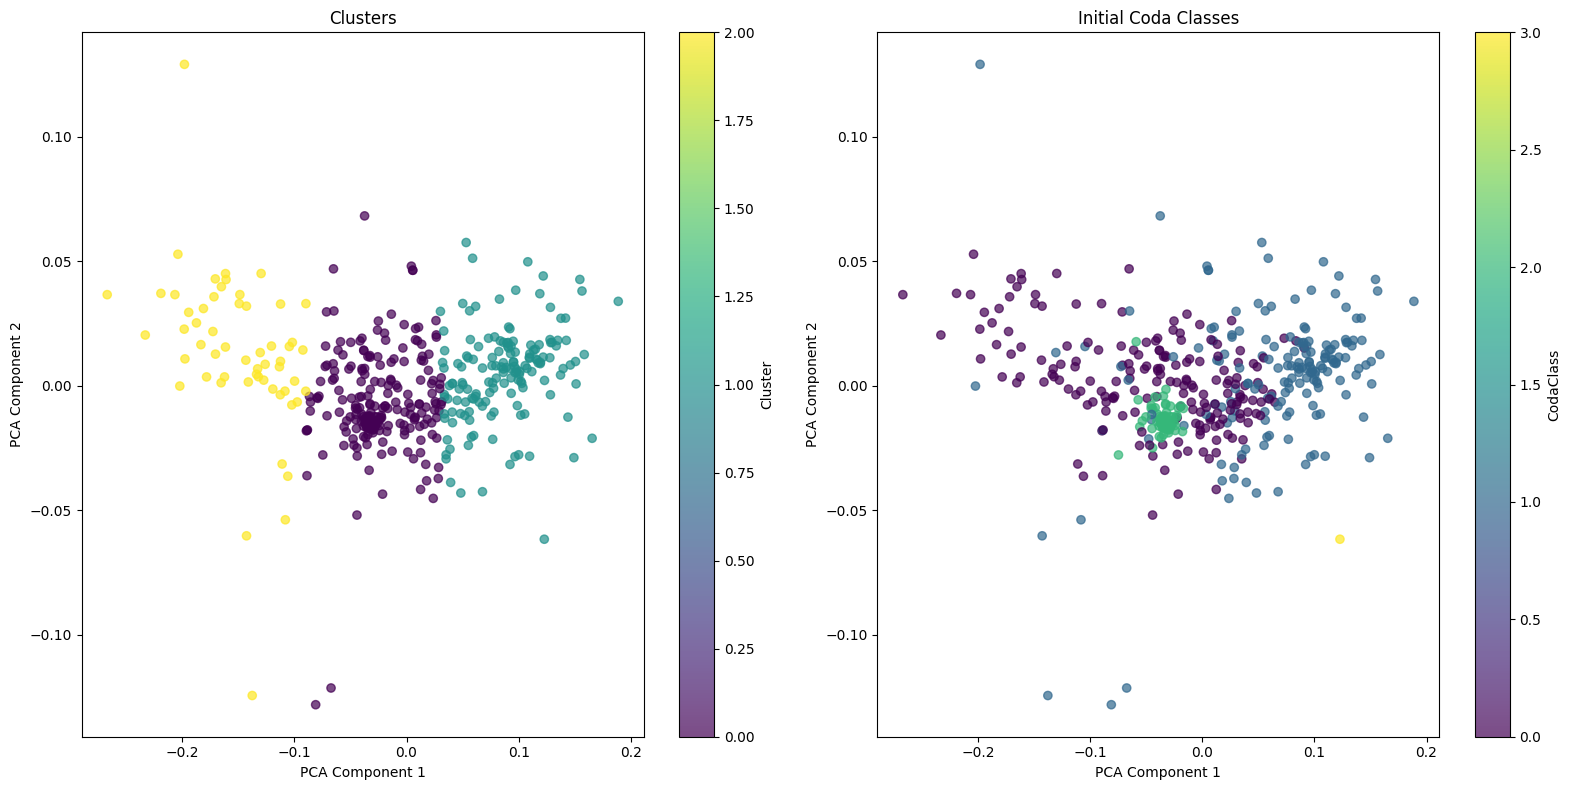

CodaClass  5-NOISE    6-NOISE         6R         6i
Cluster                                            
0              0.0   7.741935  43.225806  49.032258
1              0.0  46.666667   0.000000  53.333333
2              0.0  13.461538   0.000000  86.538462
3              1.0  96.000000   0.000000   3.000000
CodaClass
6i         188
6-NOISE    171
6R          67
5-NOISE      1
Name: count, dtype: int64


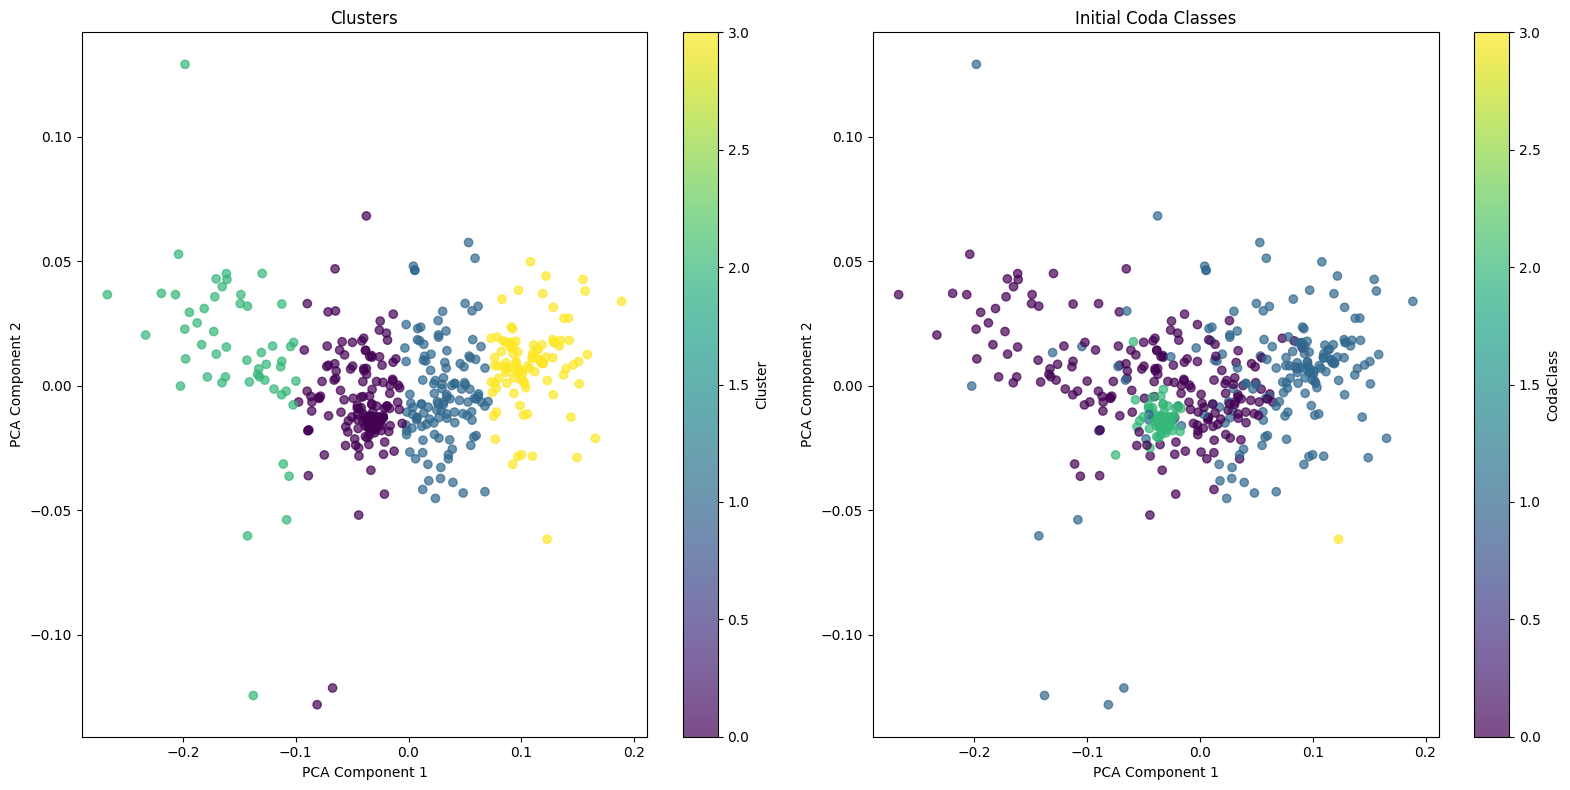

CodaClass   5-NOISE    6-NOISE         6R         6i
Cluster                                             
0          0.000000   9.027778  46.527778  44.444444
1          0.000000  76.190476   0.000000  23.809524
2          0.000000  12.500000   0.000000  87.500000
3          1.333333  97.333333   0.000000   1.333333
4          0.000000  31.958763   0.000000  68.041237
CodaClass
6i         188
6-NOISE    171
6R          67
5-NOISE      1
Name: count, dtype: int64


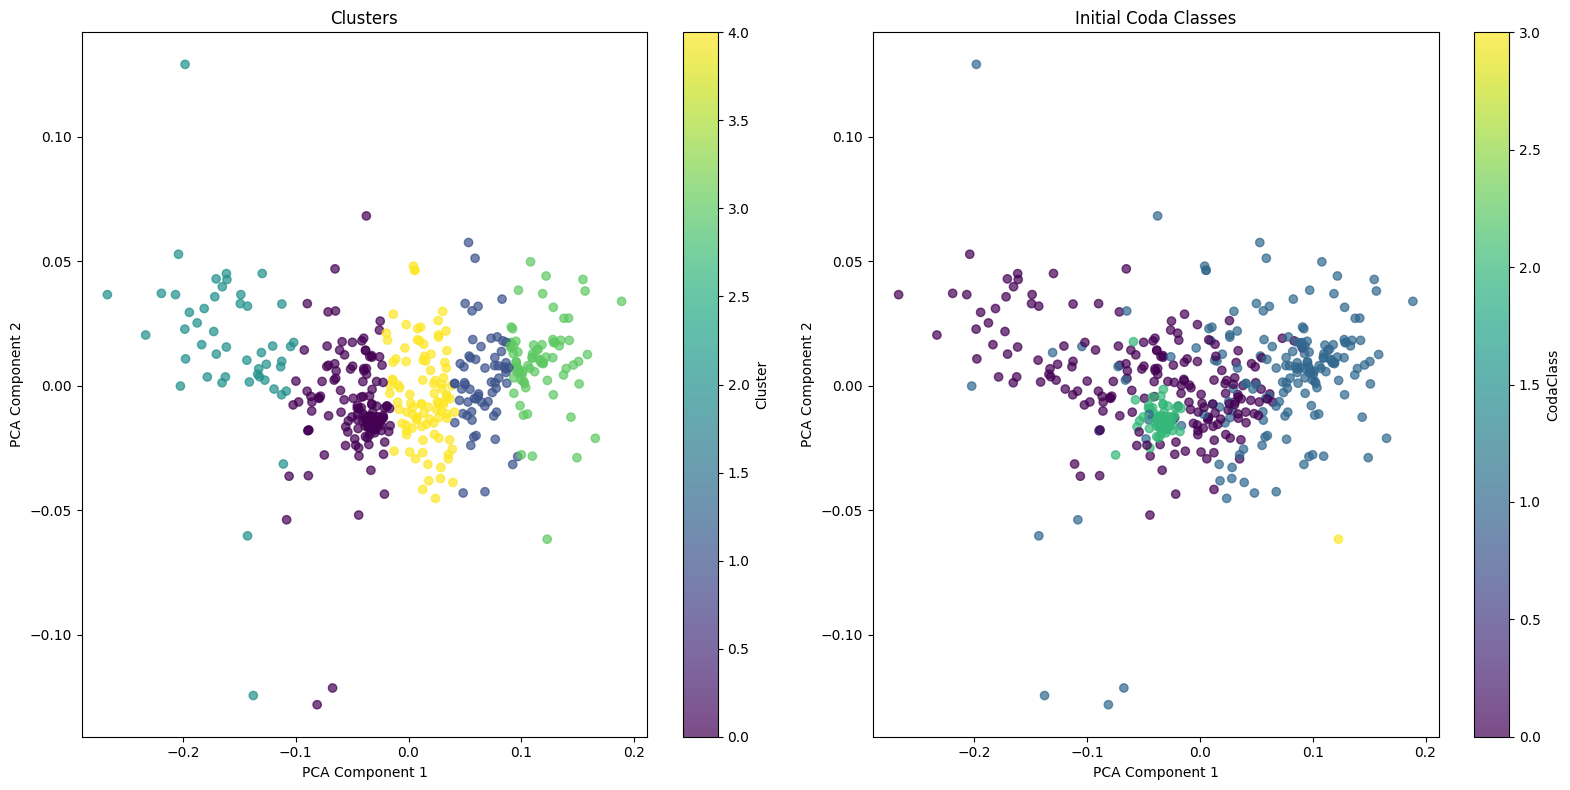

CodaClass   5-NOISE    6-NOISE         6R         6i
Cluster                                             
0          0.000000   6.153846  50.769231  43.076923
1          0.000000  78.260870   0.000000  21.739130
2          0.000000   6.896552   0.000000  93.103448
3          1.538462  98.461538   0.000000   0.000000
4          0.000000  38.636364   0.000000  61.363636
5          0.000000  19.565217   2.173913  78.260870
CodaClass
6i         188
6-NOISE    171
6R          67
5-NOISE      1
Name: count, dtype: int64


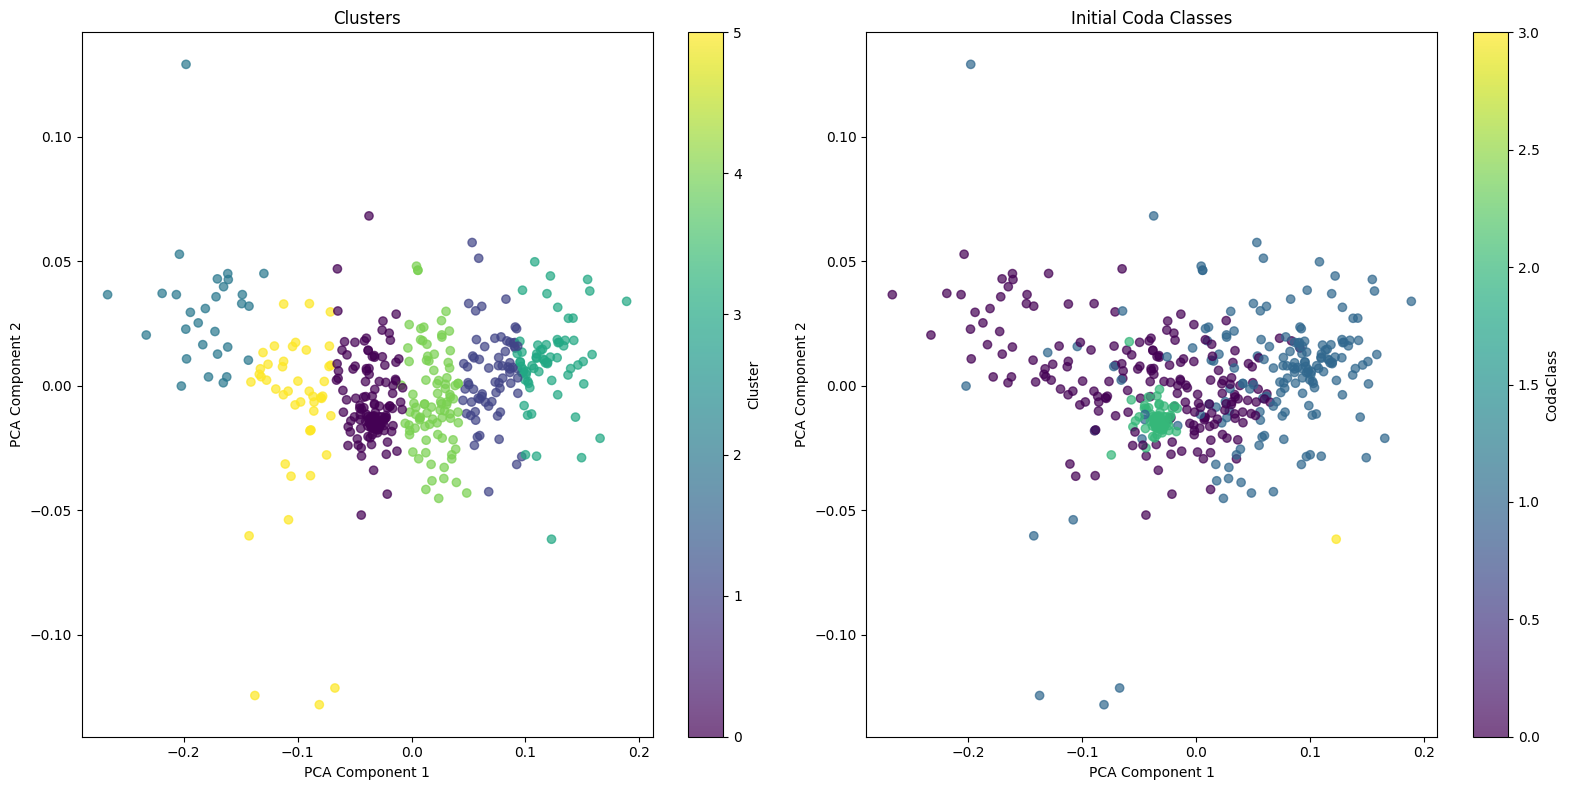

CodaClass   7-NOISE        7D1        7D2         7R         7i
Cluster                                                        
0          5.882353   7.486631   0.000000  12.299465  74.331551
1          3.669725  74.770642  16.055046   0.000000   5.504587
CodaClass
7D1        177
7i         151
7D2         35
7R          23
7-NOISE     19
Name: count, dtype: int64


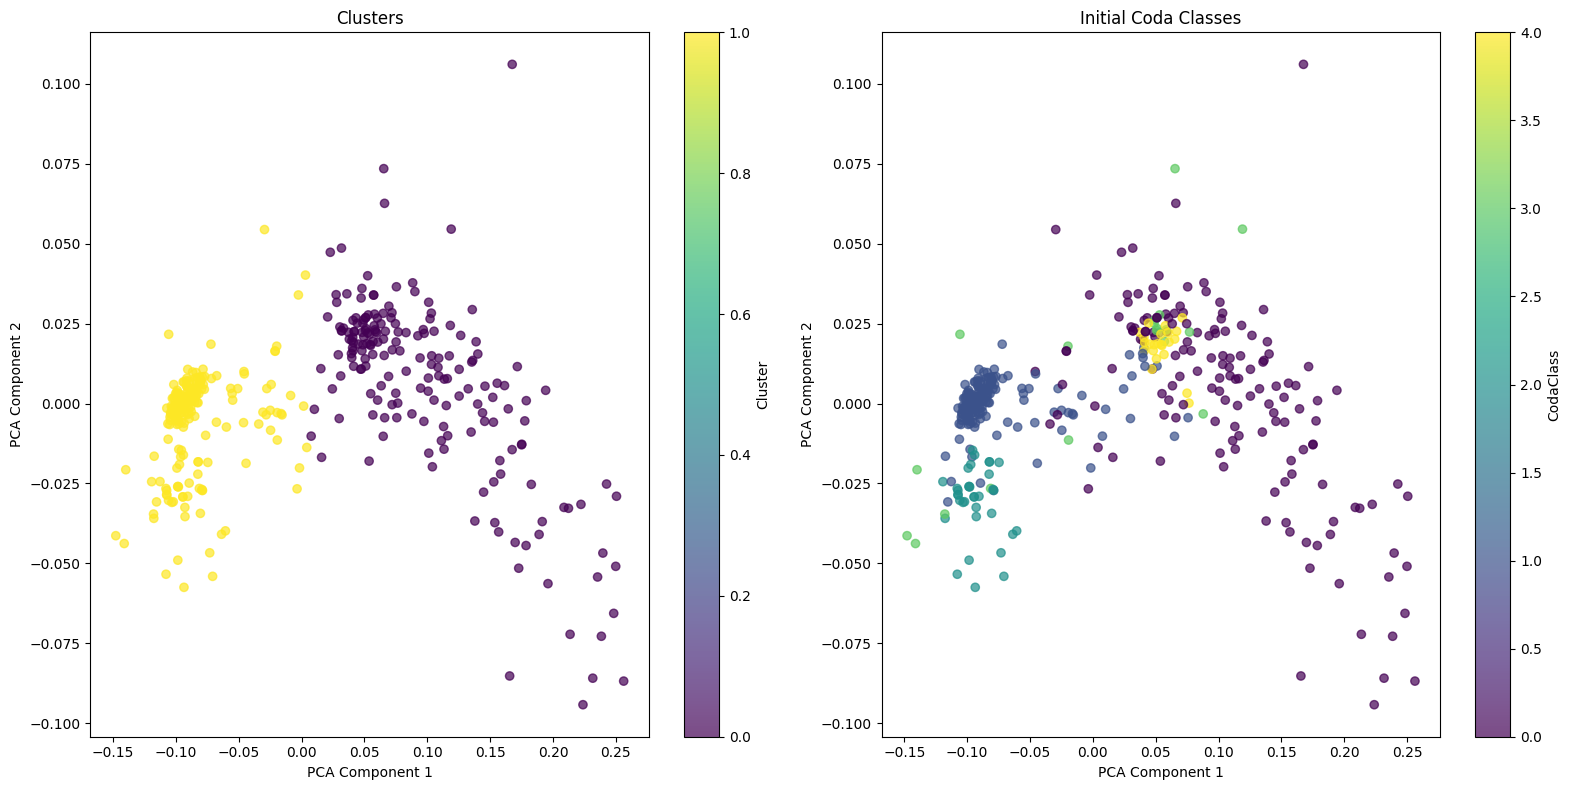

CodaClass   7-NOISE        7D1        7D2         7R          7i
Cluster                                                         
0          0.000000   0.000000   0.000000   0.000000  100.000000
1          3.791469  76.303318  16.587678   0.000000    3.317536
2          8.029197  11.678832   0.000000  16.788321   63.503650
CodaClass
7D1        177
7i         151
7D2         35
7R          23
7-NOISE     19
Name: count, dtype: int64


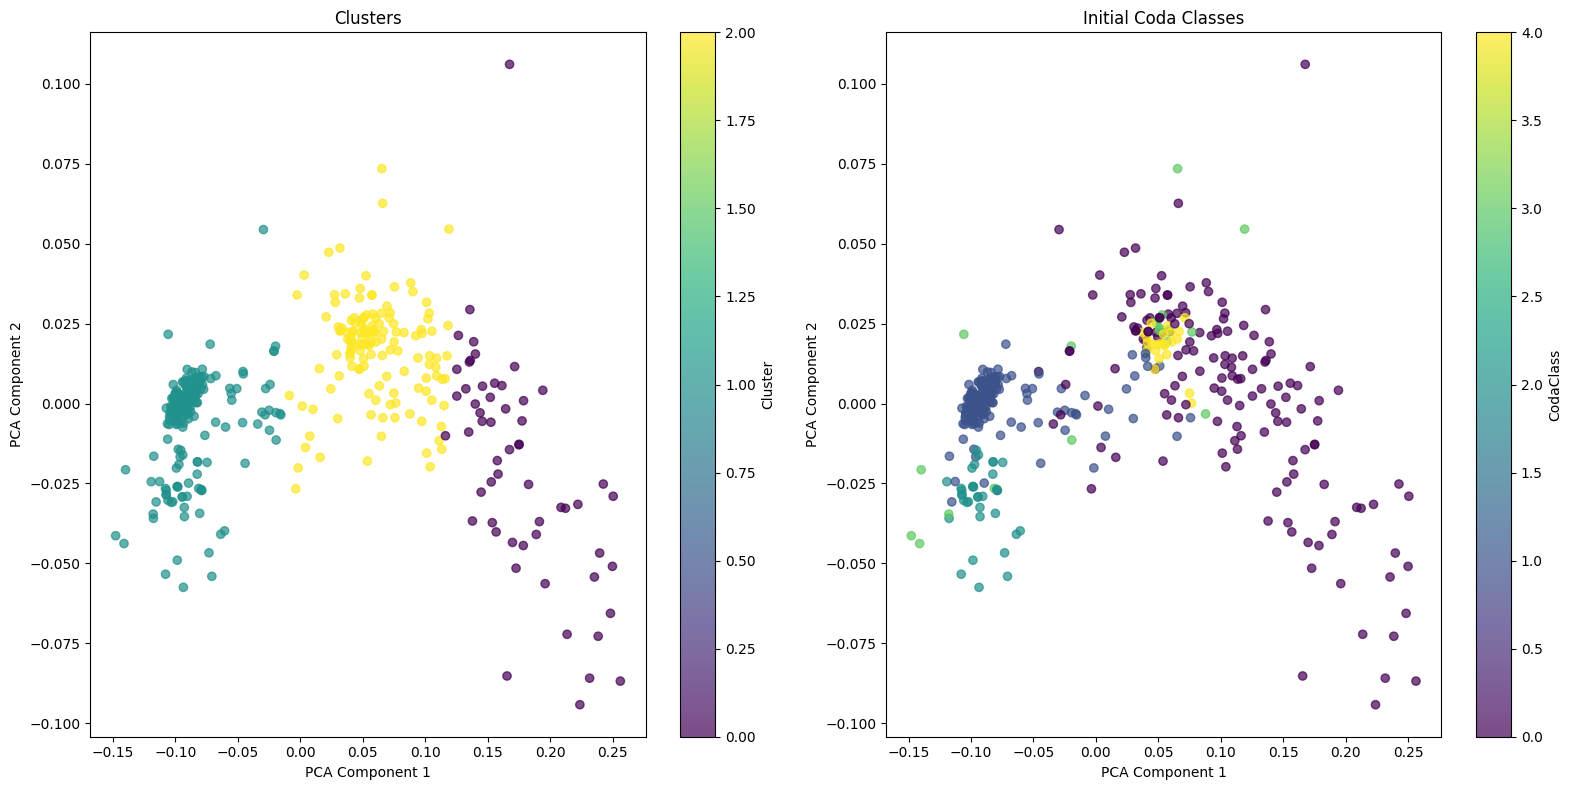

CodaClass   7-NOISE        7D1        7D2         7R          7i
Cluster                                                         
0          3.333333   0.000000   0.000000   0.000000   96.666667
1          2.955665  77.832512  17.241379   0.000000    1.970443
2          9.909910  17.117117   0.000000  20.720721   52.252252
3          0.000000   0.000000   0.000000   0.000000  100.000000
CodaClass
7D1        177
7i         151
7D2         35
7R          23
7-NOISE     19
Name: count, dtype: int64


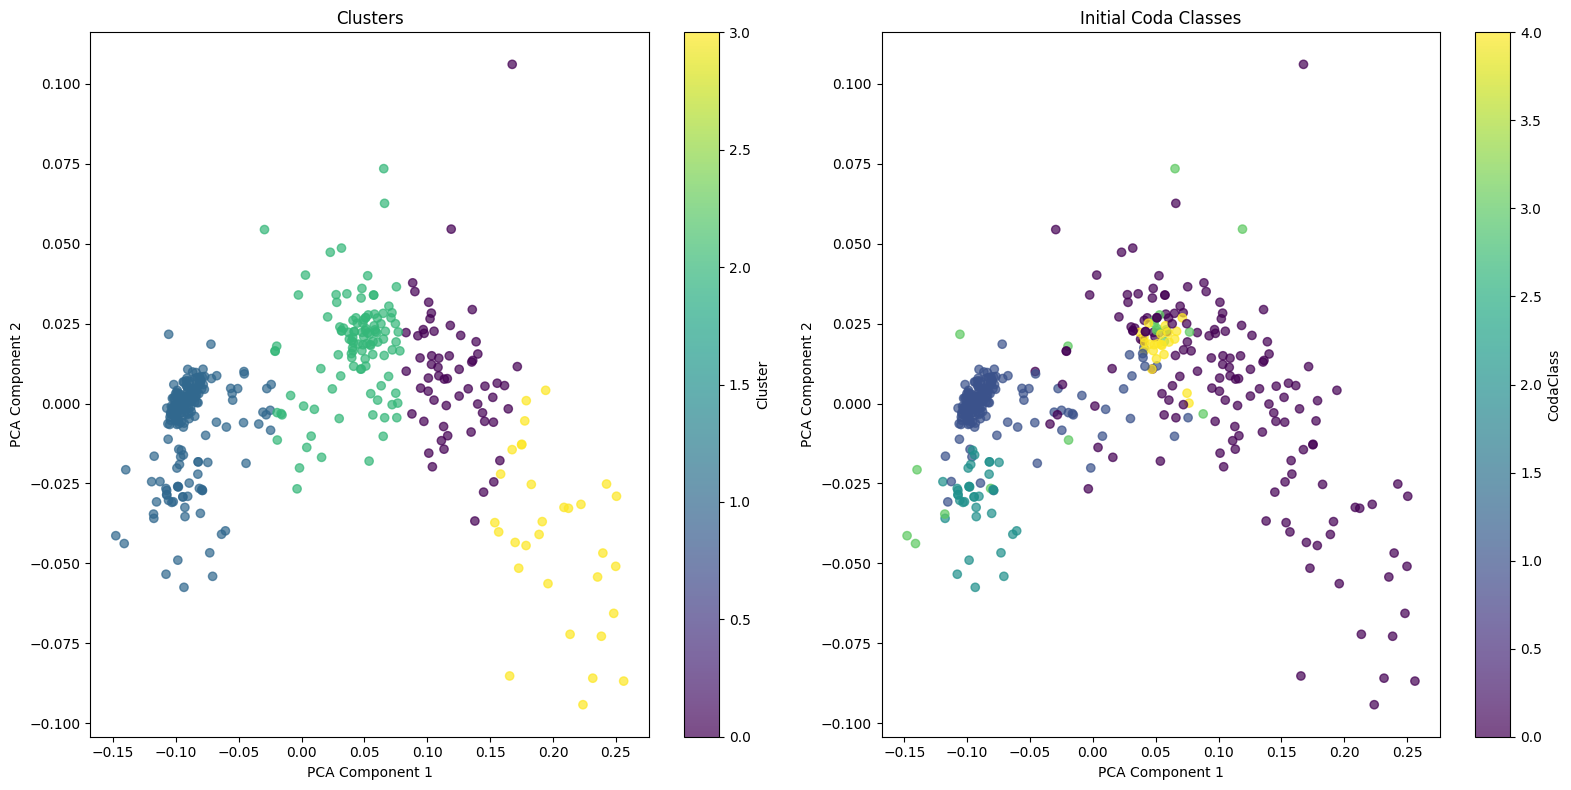

CodaClass    7-NOISE        7D1        7D2         7R          7i
Cluster                                                          
0           3.389831   0.000000   0.000000   0.000000   96.610169
1           1.250000  96.250000   0.000000   0.000000    2.500000
2           9.090909  16.363636   0.000000  20.909091   53.636364
3           0.000000   0.000000   0.000000   0.000000  100.000000
4          11.111111  11.111111  77.777778   0.000000    0.000000
CodaClass
7D1        177
7i         151
7D2         35
7R          23
7-NOISE     19
Name: count, dtype: int64


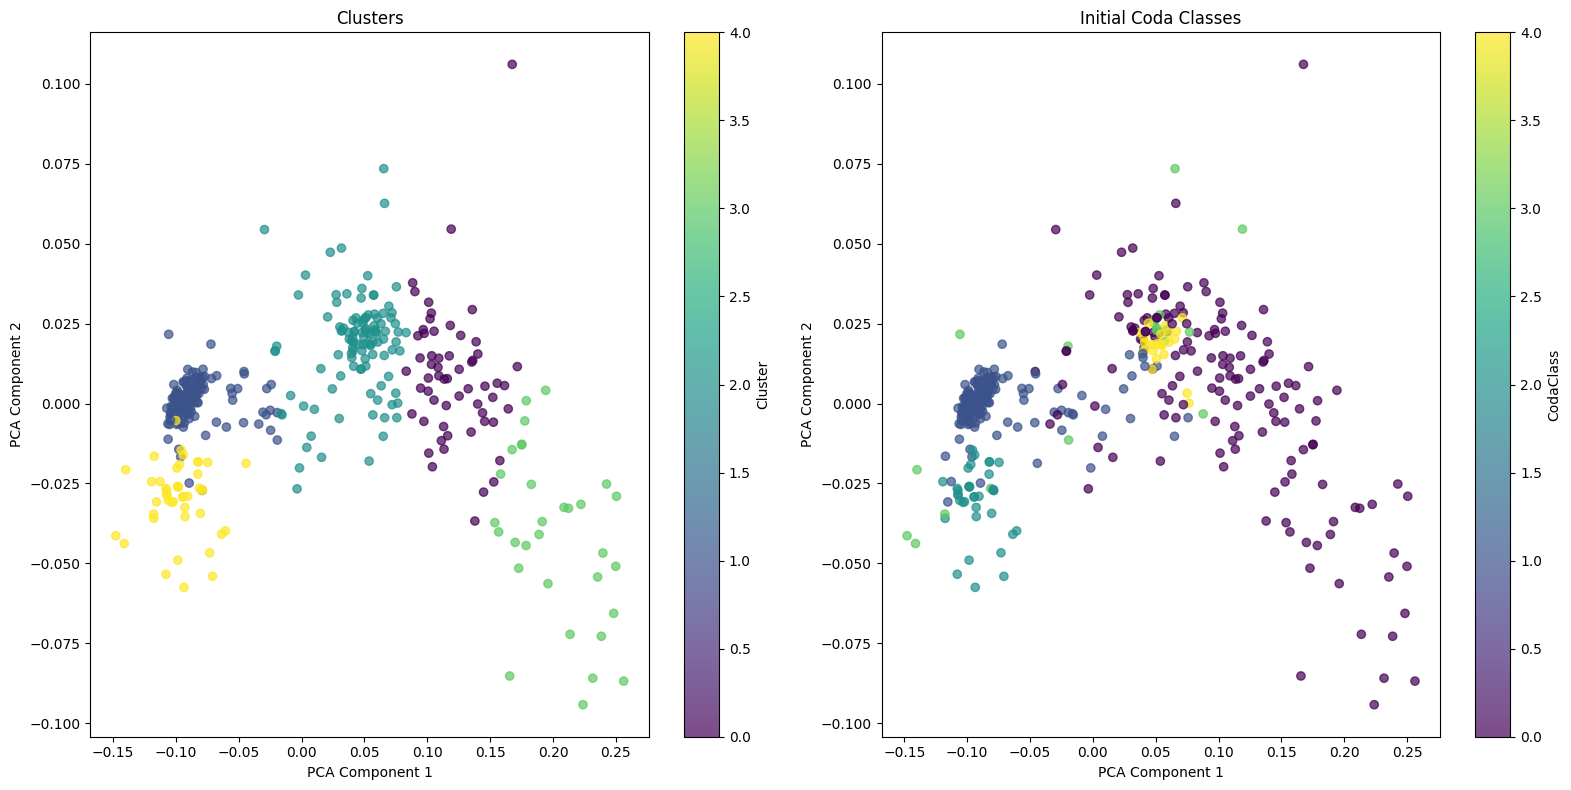

CodaClass    7-NOISE        7D1        7D2         7R          7i
Cluster                                                          
0          10.204082  12.244898   0.000000  23.469388   54.081633
1           0.699301  99.300699   0.000000   0.000000    0.000000
2           5.714286  54.285714   0.000000   0.000000   40.000000
3           0.000000   0.000000   0.000000   0.000000  100.000000
4          11.363636   9.090909  79.545455   0.000000    0.000000
5           1.612903   0.000000   0.000000   0.000000   98.387097
CodaClass
7D1        177
7i         151
7D2         35
7R          23
7-NOISE     19
Name: count, dtype: int64


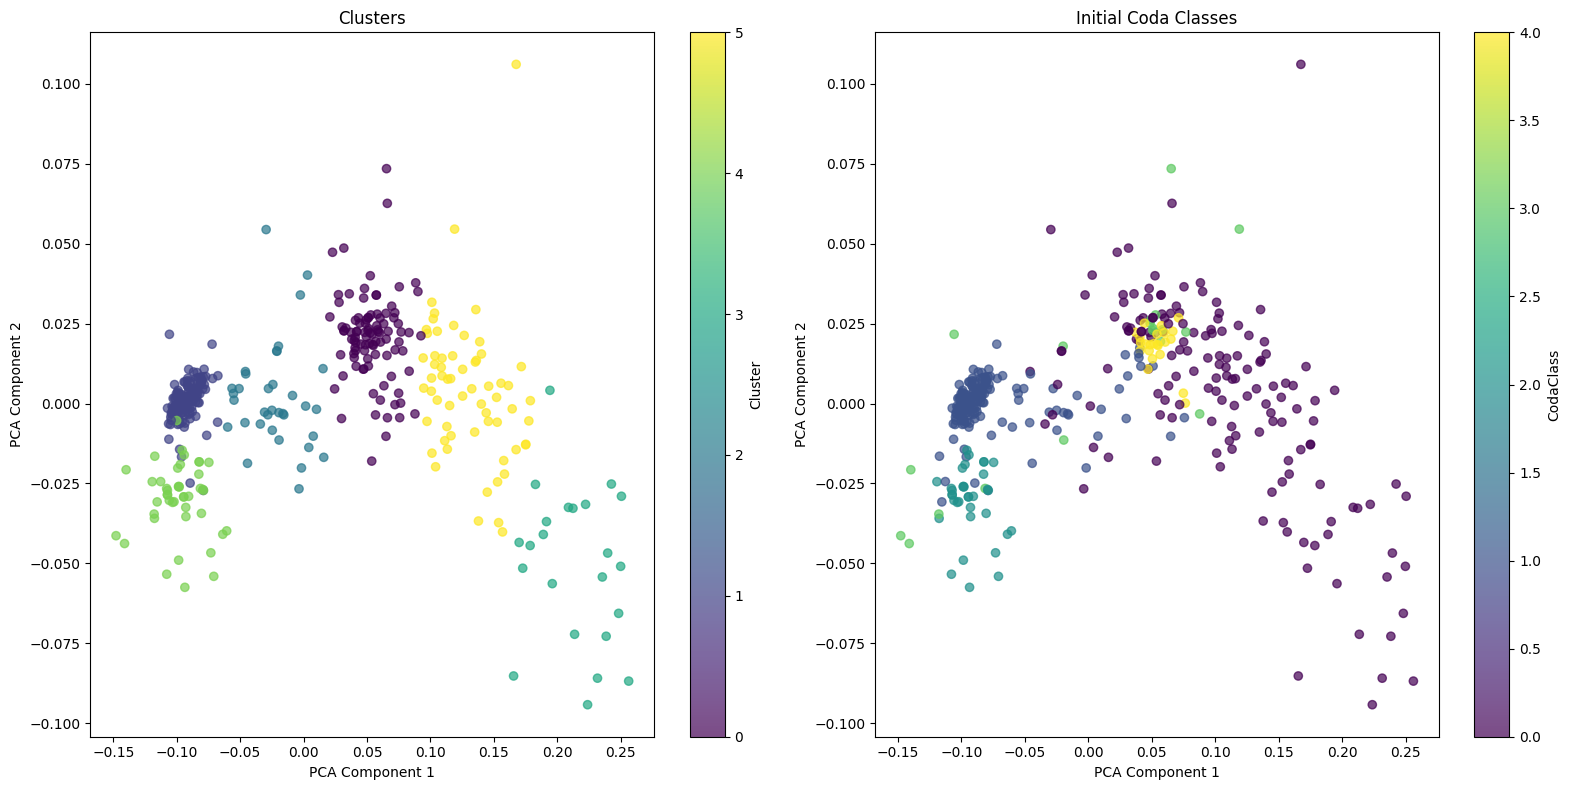

CodaClass   8-NOISE         8D         8R         8i
Cluster                                             
0          5.188679   0.000000  12.735849  82.075472
1          9.523810  31.746032  52.380952   6.349206
CodaClass
8i         178
8R          60
8D          20
8-NOISE     17
Name: count, dtype: int64


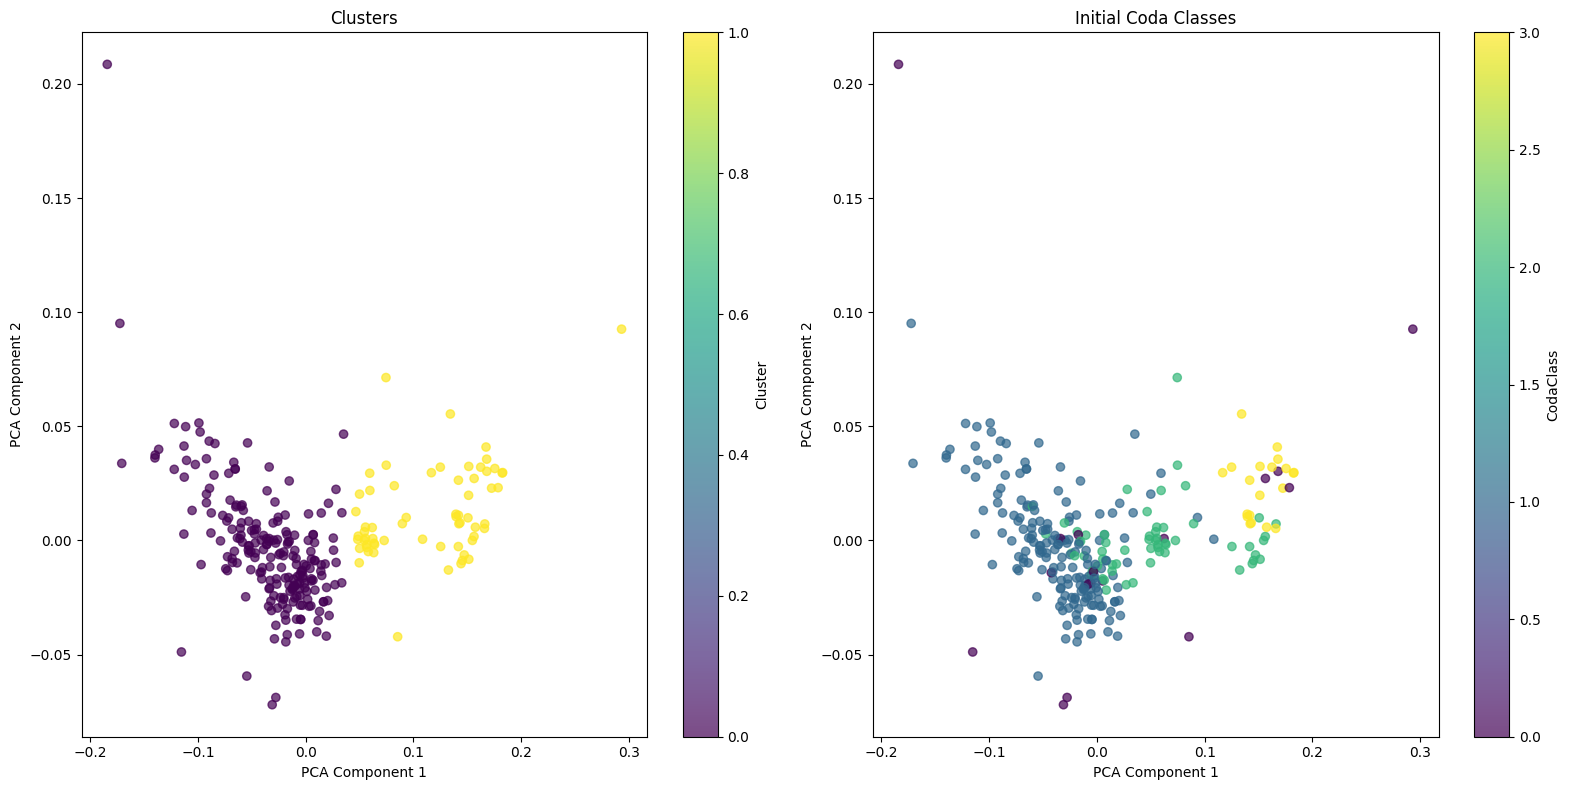

CodaClass    8-NOISE         8D         8R         8i
Cluster                                              
0           6.369427   0.000000  26.751592  66.878981
1          11.627907  46.511628  37.209302   4.651163
2           2.666667   0.000000   2.666667  94.666667
CodaClass
8i         178
8R          60
8D          20
8-NOISE     17
Name: count, dtype: int64


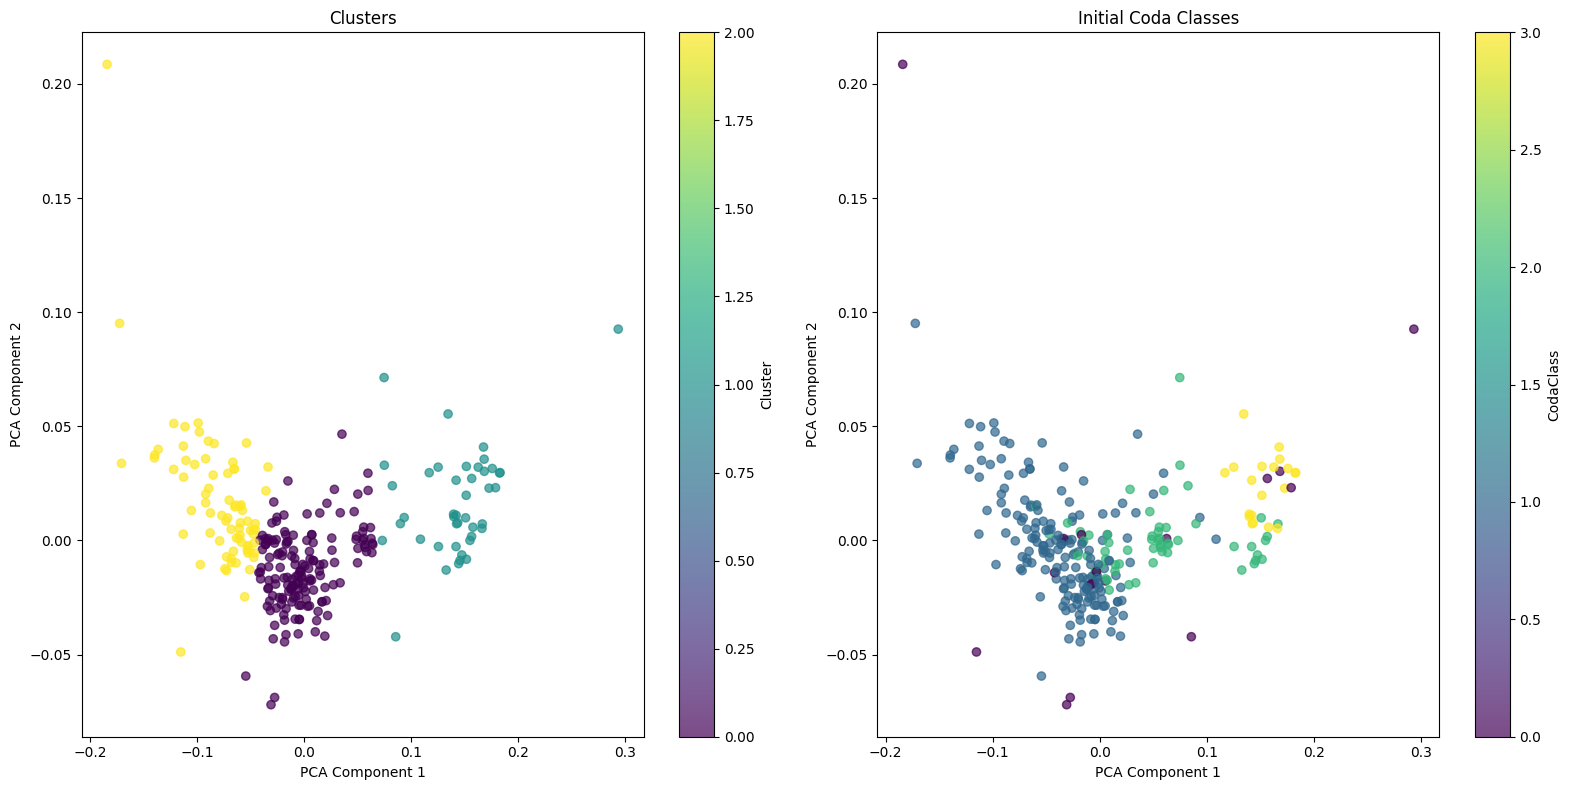

CodaClass    8-NOISE         8D         8R         8i
Cluster                                              
0           6.250000   0.000000  15.277778  78.472222
1          11.111111  55.555556  30.555556   2.777778
2           3.448276   0.000000   1.724138  94.827586
3           5.405405   0.000000  70.270270  24.324324
CodaClass
8i         178
8R          60
8D          20
8-NOISE     17
Name: count, dtype: int64


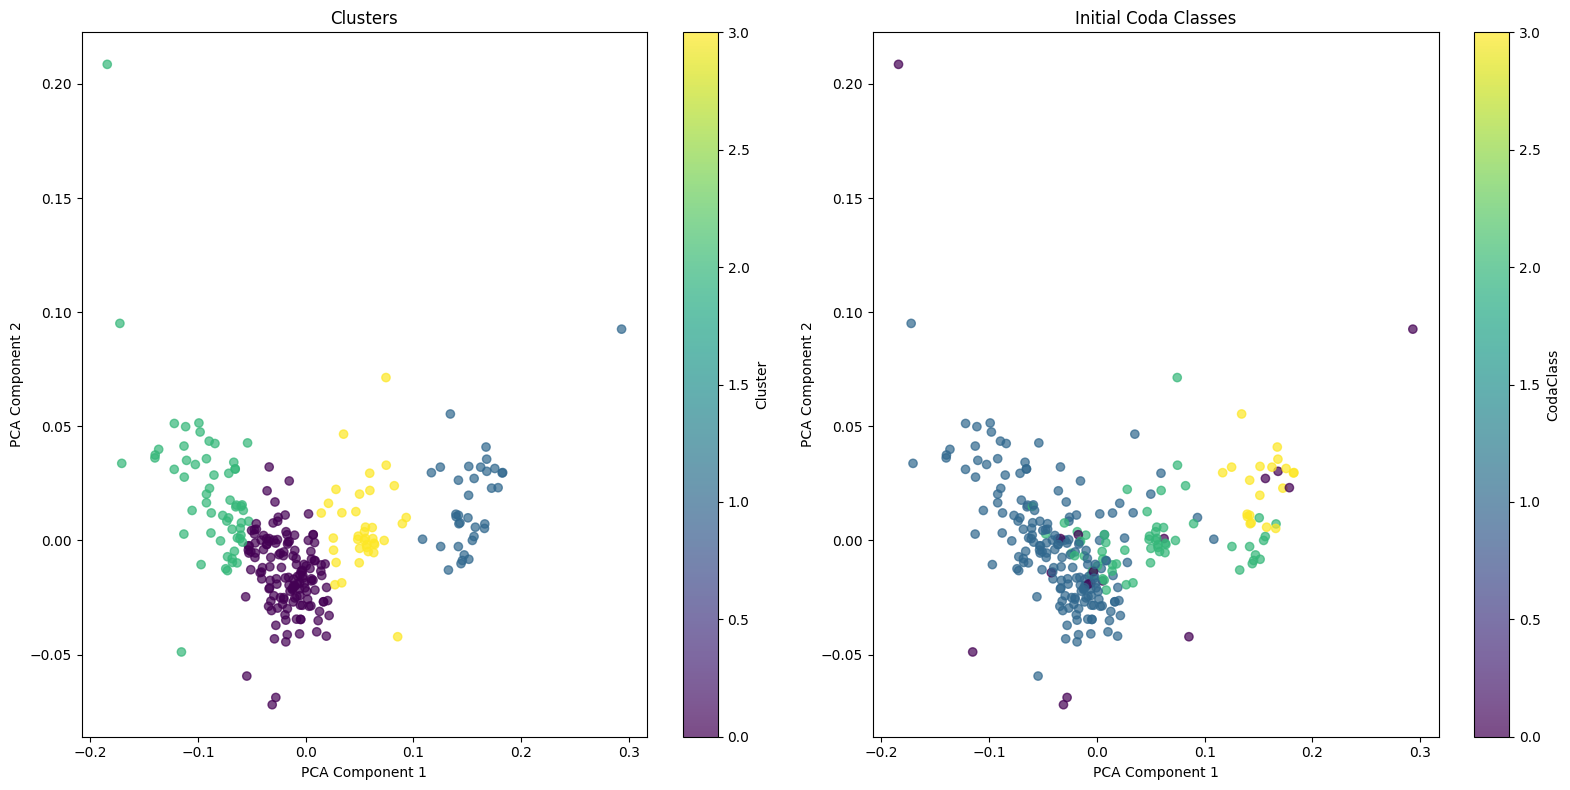

CodaClass    8-NOISE         8D         8R         8i
Cluster                                              
0           4.347826   0.000000   4.347826  91.304348
1          11.111111  55.555556  30.555556   2.777778
2           4.166667   0.000000   0.000000  95.833333
3           5.555556   0.000000  72.222222  22.222222
4           6.363636   0.000000  18.181818  75.454545
CodaClass
8i         178
8R          60
8D          20
8-NOISE     17
Name: count, dtype: int64


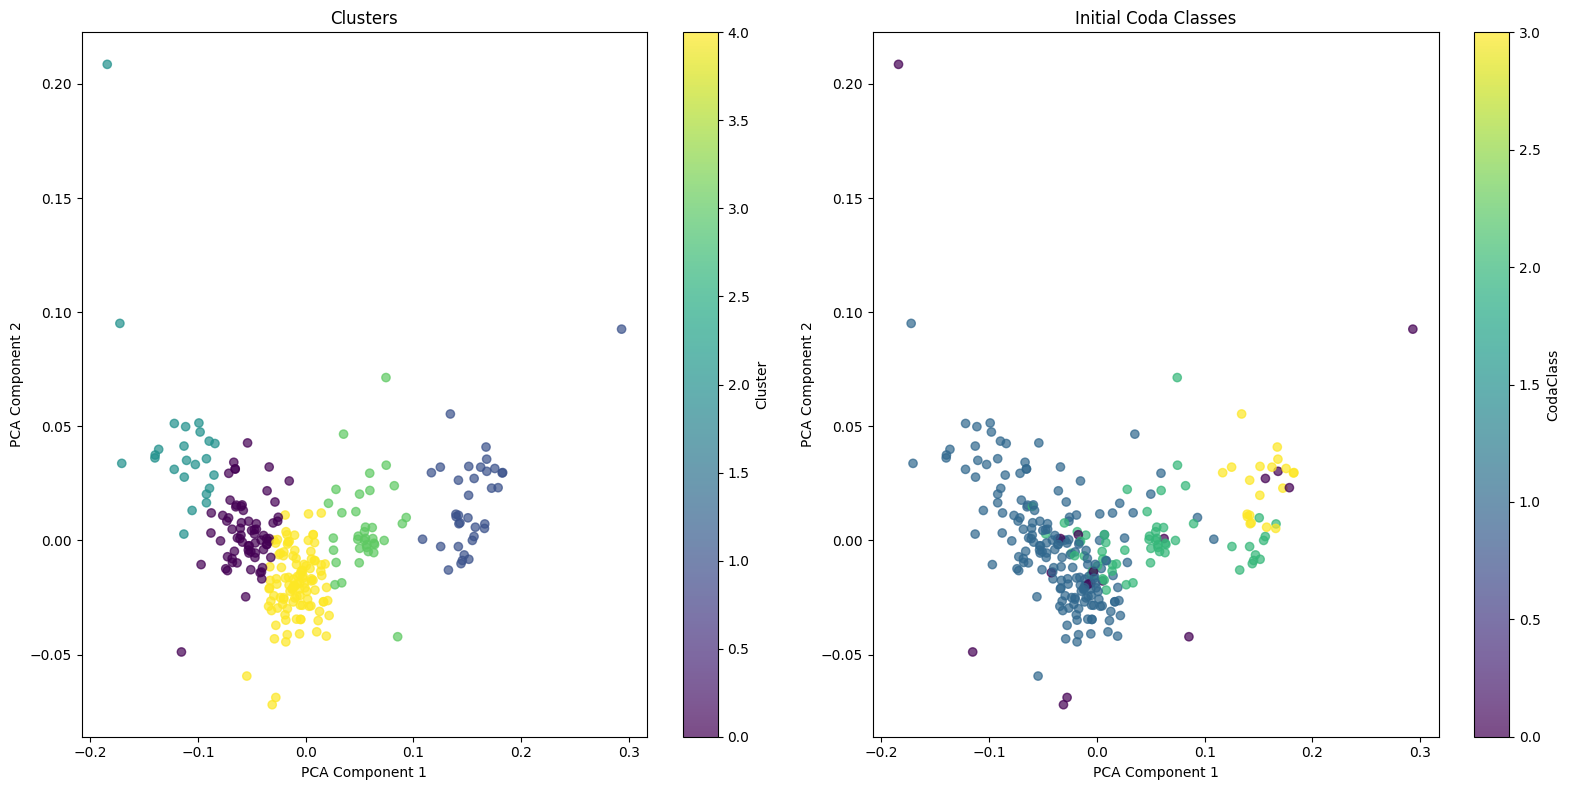

CodaClass     8-NOISE         8D         8R          8i
Cluster                                                
0            4.347826   0.000000   4.347826   91.304348
1           11.111111  55.555556  30.555556    2.777778
2            0.000000   0.000000   0.000000  100.000000
3            5.555556   0.000000  72.222222   22.222222
4            6.422018   0.000000  18.348624   75.229358
5          100.000000   0.000000   0.000000    0.000000
CodaClass
8i         178
8R          60
8D          20
8-NOISE     17
Name: count, dtype: int64


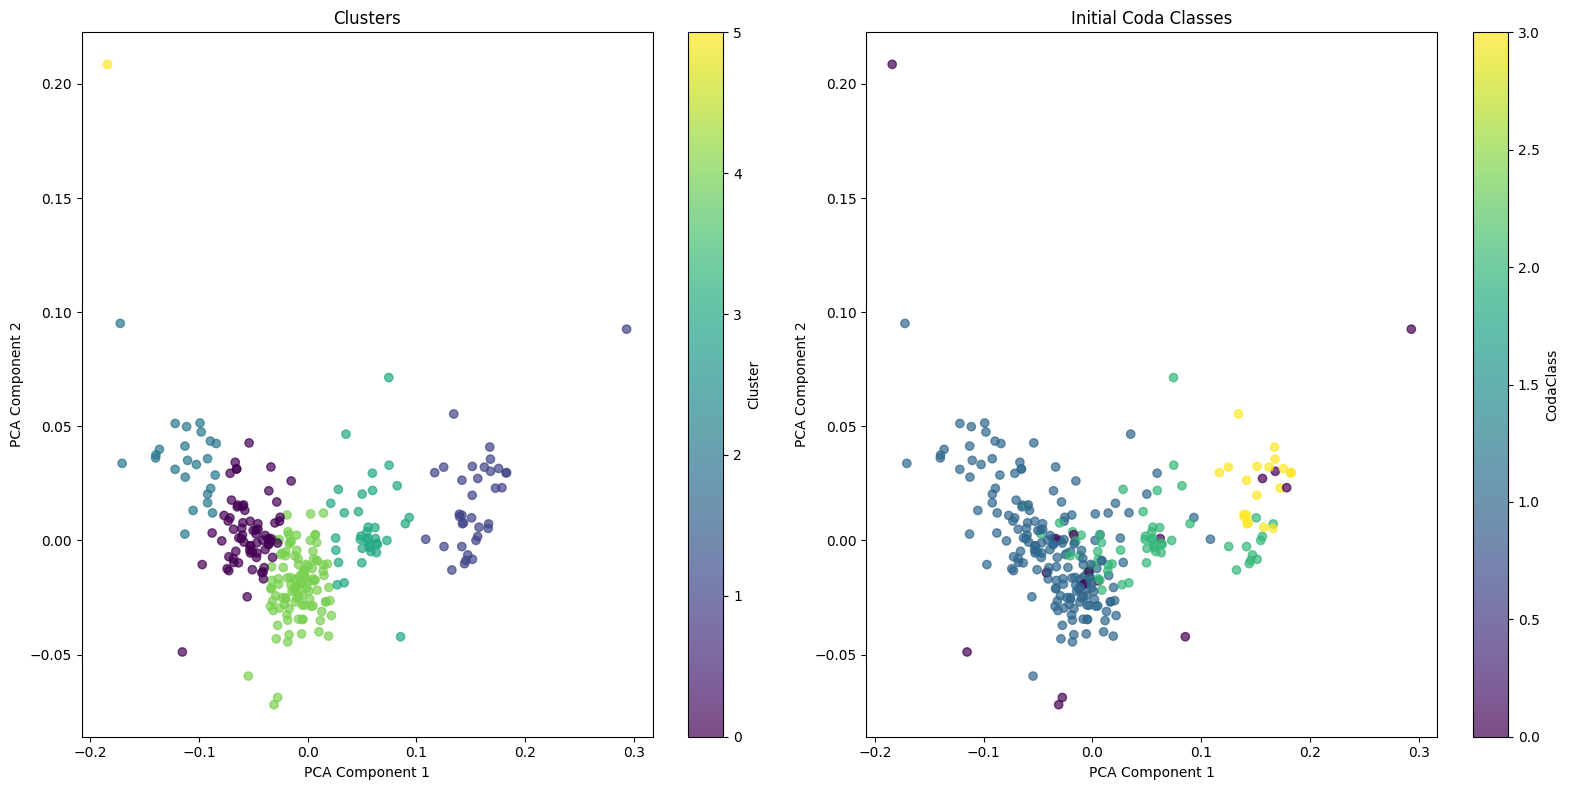

CodaClass    9-NOISE         9R         9i
Cluster                                   
0           1.666667  22.777778  75.555556
1          81.250000  12.500000   6.250000
CodaClass
9i         137
9R          43
9-NOISE     16
Name: count, dtype: int64


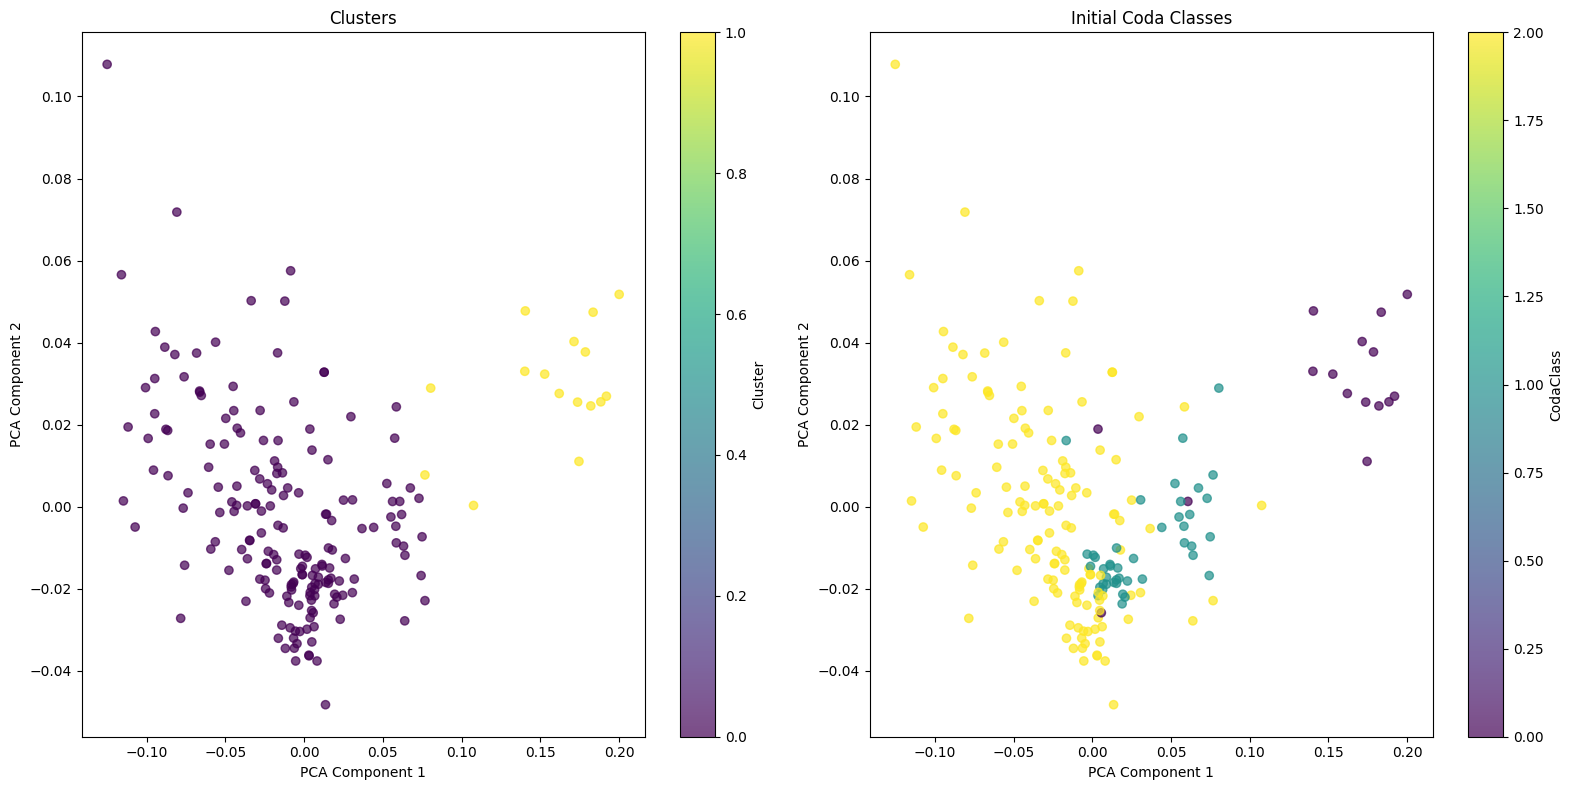

CodaClass    9-NOISE         9R          9i
Cluster                                    
0           2.272727  31.818182   65.909091
1          86.666667   6.666667    6.666667
2           0.000000   0.000000  100.000000
CodaClass
9i         137
9R          43
9-NOISE     16
Name: count, dtype: int64


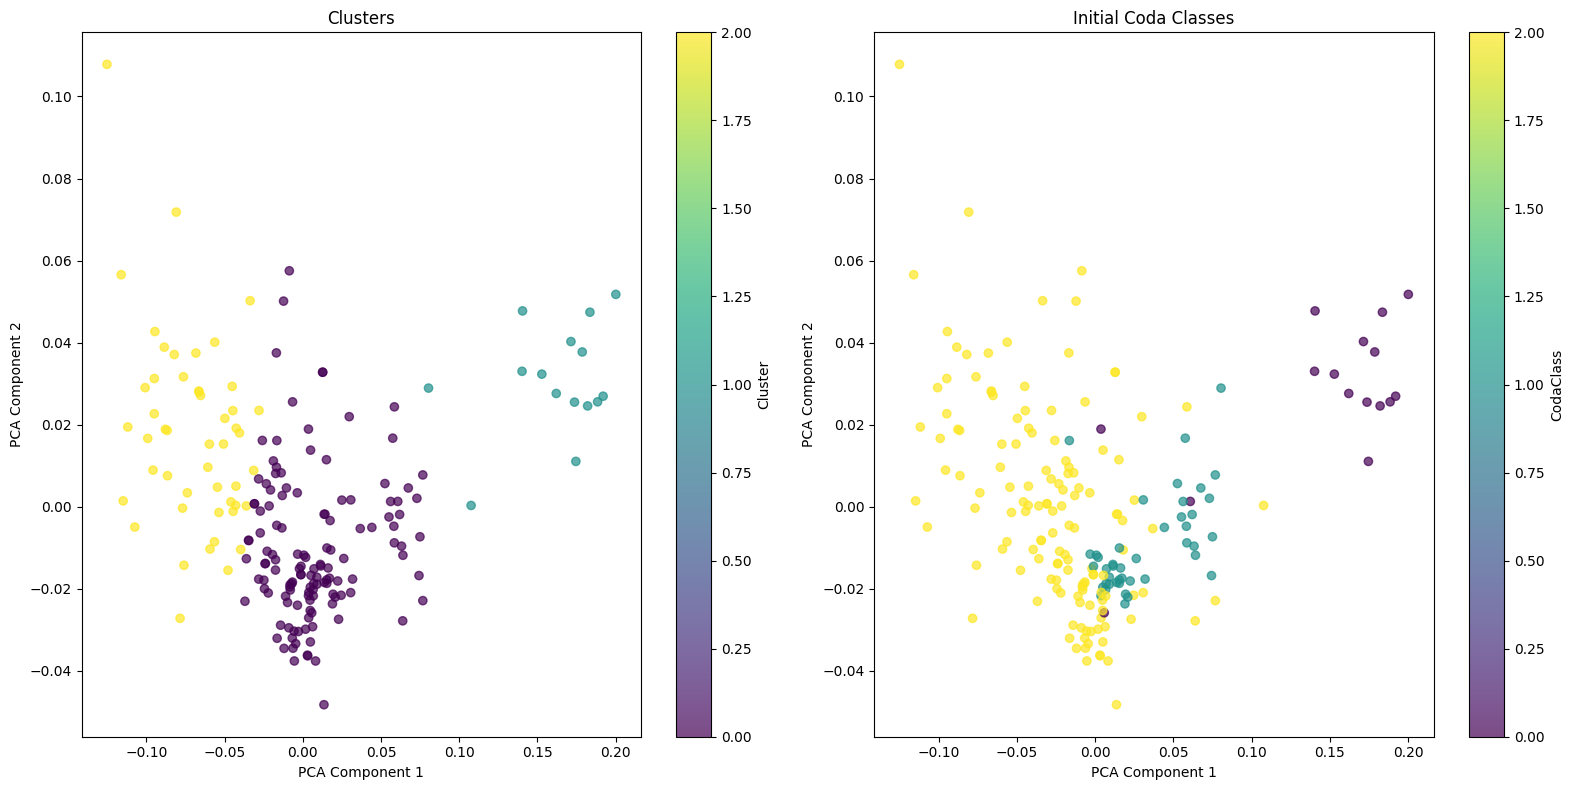

CodaClass     9-NOISE         9R          9i
Cluster                                     
0            1.754386  21.929825   76.315789
1          100.000000   0.000000    0.000000
2            0.000000   0.000000  100.000000
3            4.000000  72.000000   24.000000
CodaClass
9i         137
9R          43
9-NOISE     16
Name: count, dtype: int64


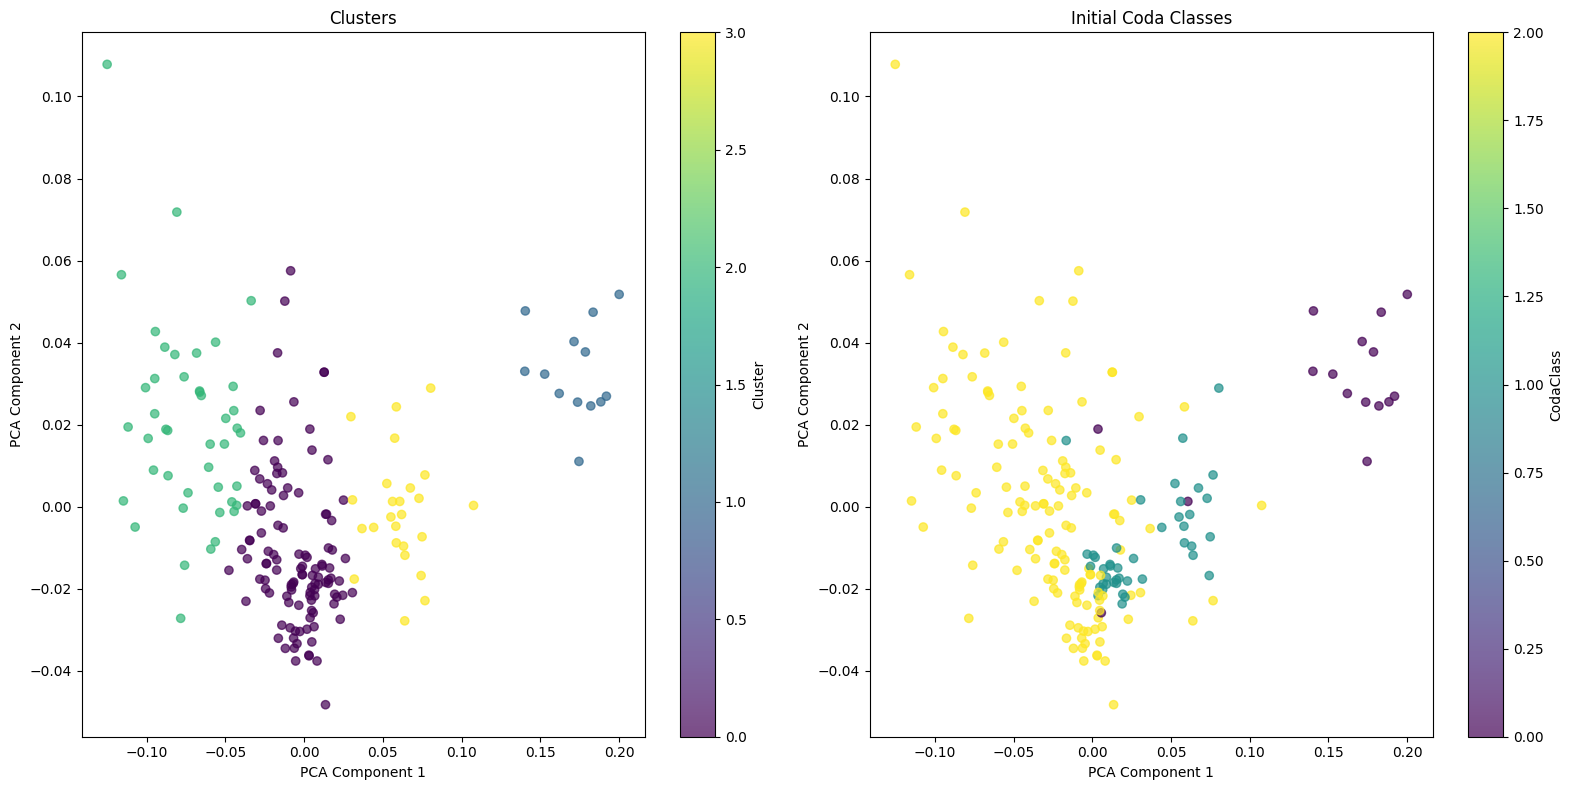

CodaClass     9-NOISE         9R          9i
Cluster                                     
0            2.597403  33.766234   63.636364
1          100.000000   0.000000    0.000000
2            0.000000   0.000000  100.000000
3            4.347826  69.565217   26.086957
4            0.000000   1.818182   98.181818
CodaClass
9i         137
9R          43
9-NOISE     16
Name: count, dtype: int64


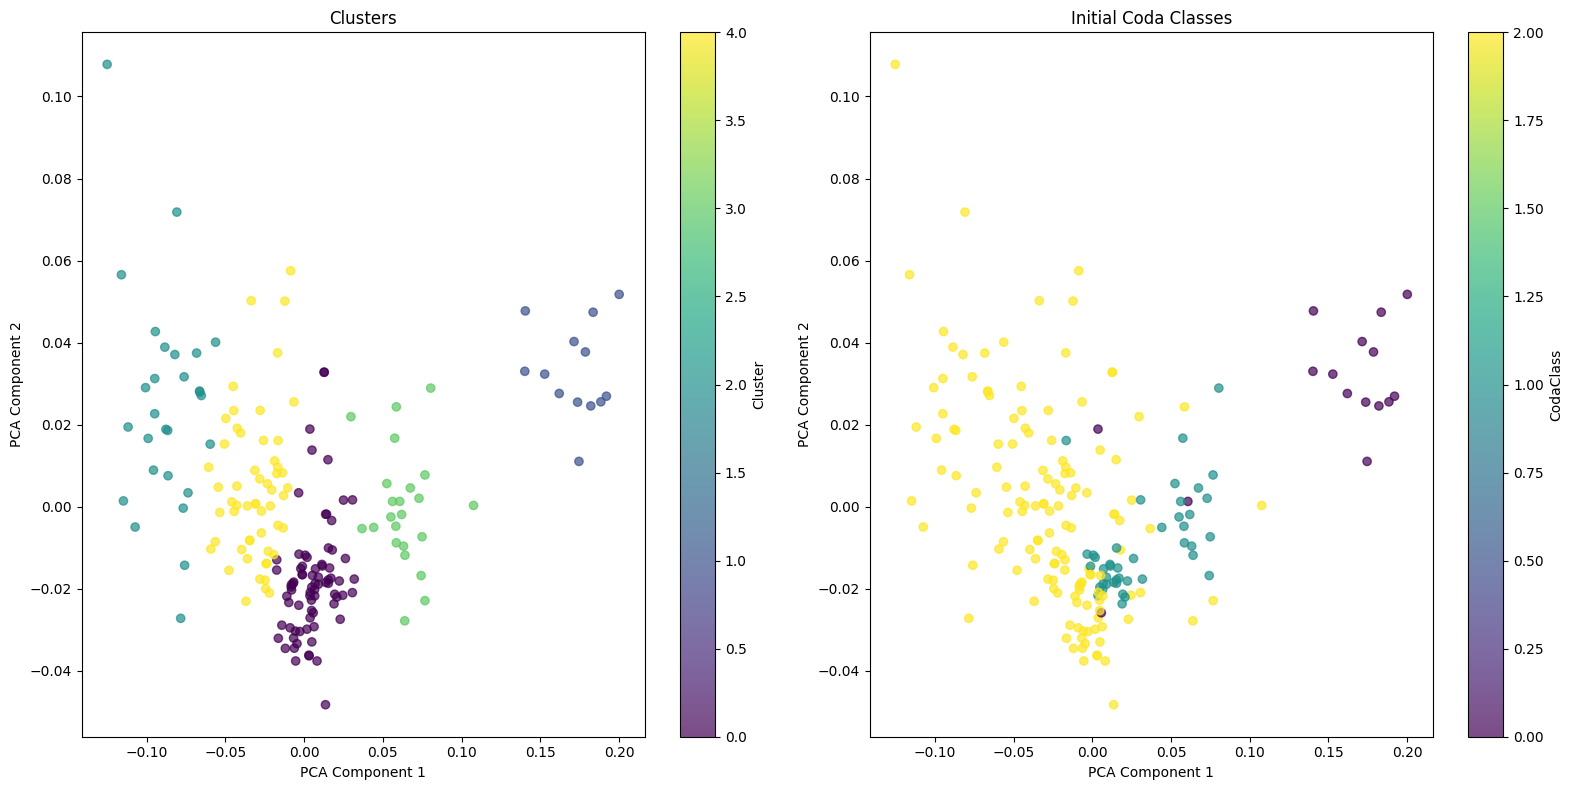

CodaClass     9-NOISE         9R          9i
Cluster                                     
0            1.351351  33.783784   64.864865
1          100.000000   0.000000    0.000000
2            0.000000   0.000000  100.000000
3            4.166667  70.833333   25.000000
4            1.818182   1.818182   96.363636
5            0.000000   0.000000  100.000000
CodaClass
9i         137
9R          43
9-NOISE     16
Name: count, dtype: int64


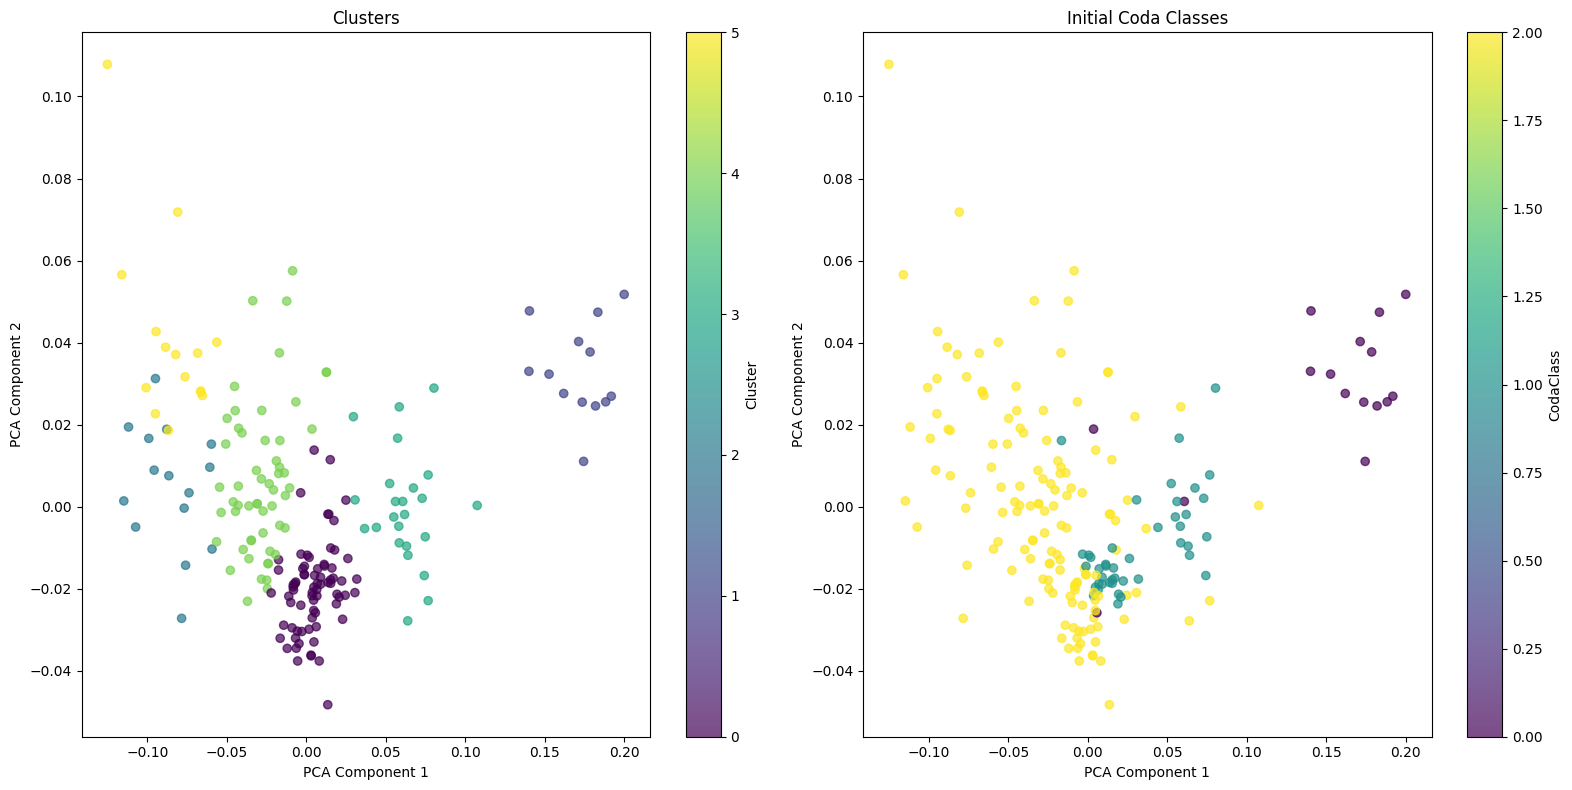

In [46]:
nums_clicks = ['3', '4', '5', '6', '7', '8', '9']
for num_clicks in nums_clicks:
    # Assuming 'CodaType' is the column in your DataFrame representing coda classes
    coda_classes = []  # Access the column by name


    def calculate_rhythms(data):
        all_rhythms = []
        for idx in range(1, len(data)):
            if data[idx][2] == num_clicks:# and 'NOISE' not in data[idx][-5]:
                rhythm = return_relative(idx)
                coda_classes.append(my_data[idx, -5])
                all_rhythms.append(rhythm)
        return all_rhythms

    # Assuming `my_data` is your dataset
    rhythms = calculate_rhythms(my_data)

    from sklearn.cluster import KMeans
    from sklearn.preprocessing import normalize
    from scipy.spatial.distance import euclidean
    from fastdtw import fastdtw  # For DTW, install with `pip install fastdtw`

    # Pad rhythms to the same length
    max_length = max(len(r) for r in rhythms)
    padded_rhythms = [np.pad(r, (0, max_length - len(r))) for r in rhythms]

    # Normalize data (optional)
    normalized_rhythms = normalize(padded_rhythms)

    for n in range(2, 7):
        # Clustering
        kmeans = KMeans(n_clusters=n, random_state=0)  # Adjust the number of clusters
        clusters = kmeans.fit_predict(normalized_rhythms)
        clusters
        
        # Combine cluster labels with codaClass
        results_df = pd.DataFrame({
            'Cluster': clusters,
            'CodaClass': coda_classes
        })

        # Calculate percentages
        percentages = results_df.groupby(['Cluster', 'CodaClass']).size().unstack(fill_value=0)
        percentages = percentages.div(percentages.sum(axis=1), axis=0) * 100

        # Display results
        print(percentages)

        from sklearn.decomposition import PCA
        import matplotlib.pyplot as plt

        # Reduce dimensions for visualization
        pca = PCA(n_components=2)
        reduced_rhythms = pca.fit_transform(normalized_rhythms)

        # Create a DataFrame for combined data
        visualization_df = pd.DataFrame({
            'PCA1': reduced_rhythms[:, 0],
            'PCA2': reduced_rhythms[:, 1],
            'Cluster': clusters,
            'CodaClass': coda_classes
        })

        print(visualization_df['CodaClass'].value_counts())

        # Set up the figure and axes
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))

        # Plot 1: Clusters
        scatter1 = axes[0].scatter(
            visualization_df['PCA1'], 
            visualization_df['PCA2'], 
            c=visualization_df['Cluster'], 
            cmap='viridis', 
            alpha=0.7
        )
        axes[0].set_title('Clusters')
        axes[0].set_xlabel('PCA Component 1')
        axes[0].set_ylabel('PCA Component 2')
        fig.colorbar(scatter1, ax=axes[0], label='Cluster')

        # Plot 2: Initial Classes
        scatter2 = axes[1].scatter(
            visualization_df['PCA1'], 
            visualization_df['PCA2'], 
            c=pd.factorize(visualization_df['CodaClass'])[0],  # Encode classes as integers
            cmap='viridis', 
            alpha=0.7
        )
        axes[1].set_title('Initial Coda Classes')
        axes[1].set_xlabel('PCA Component 1')
        axes[1].set_ylabel('PCA Component 2')
        fig.colorbar(scatter2, ax=axes[1], label='CodaClass')

        # Final layout adjustments
        plt.tight_layout()
        plt.show()


CodaClass
3D         61
3-NOISE    21
3R         21
Name: count, dtype: int64


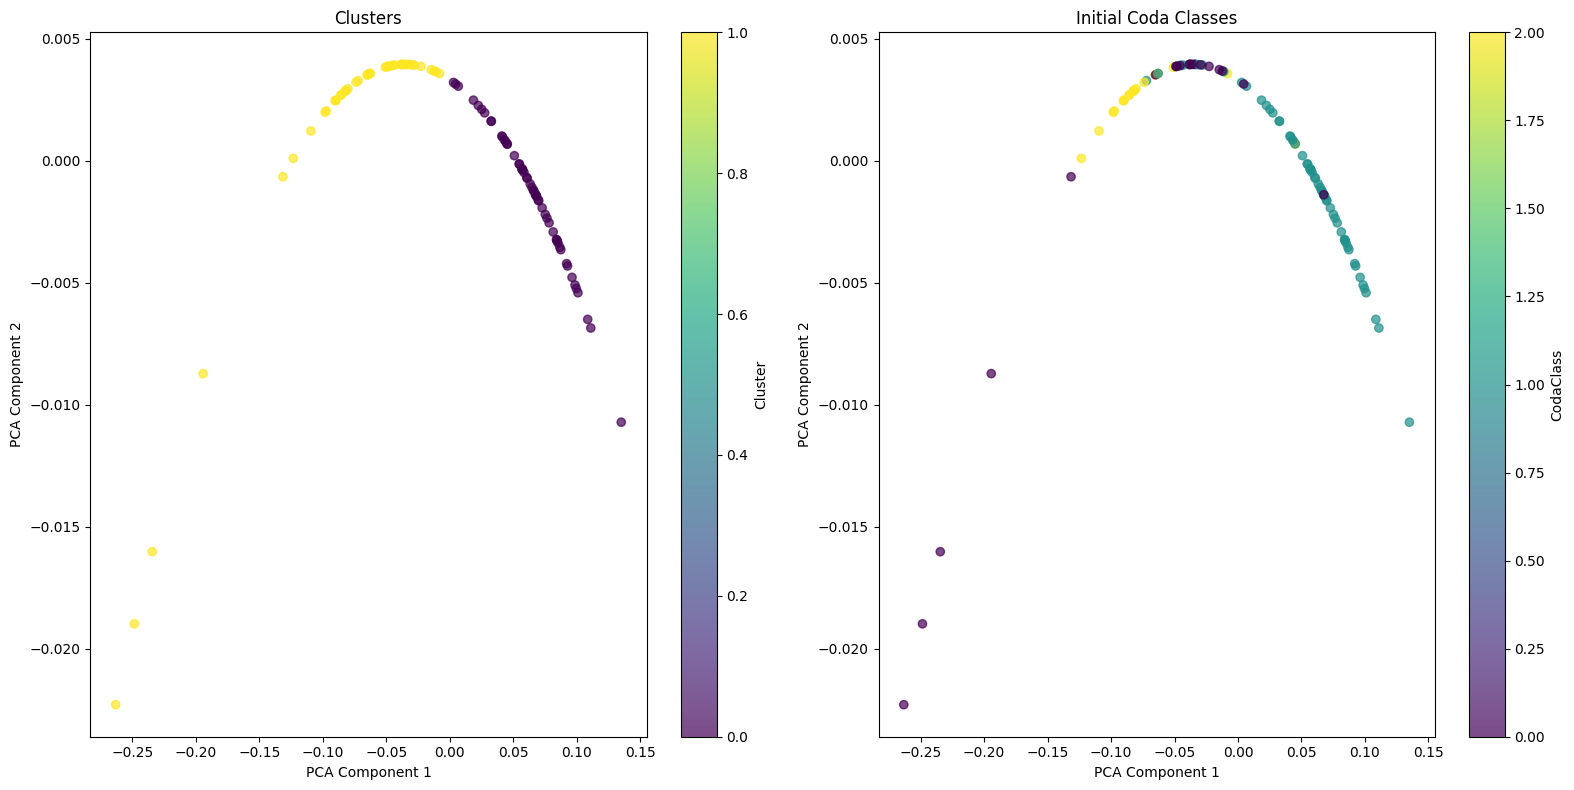